#  ============== SBA LOAN DEFAULT PREDICTION ===============

Pada notebook ini, saya akan coba memprediksi terkait SBA Loan yakni apakah seseorang atau perusahaan akan mengalami default/tidak mampu bayar atau tidak. Ini adalah project kedua saya, setelah sebelumnya saya mencoba model regressi, kali ini saya akan mencoba model klasifikasi.
Seperti biasa, notebook ini akan saya bagi menjadi beberapa tahapan sebagai berikut:
1. Konteks
2. Data Preprocessing
3. Modelling 
4. Model Tunning
5. Deployment
6. Deployment

Artikel ini tidak terlalu dalam membahas teorinya, namun saya akan memberikan alasan-alasan kenapa saya melakukan langkah-langkah tersebut dan juga saya akan mencantumkan refensinya jika ingin membaca lebih jauh. Mari kita mulai!
# **1. KONTEKS**
Small Business Administration (SBA) adalah sebuah lembaga independen pemerintahan Amerika yang membantu para pengusaha di berbagai macam industri dalam bentuk jaminan dari berbagai lembaga keuangan seperti bank atau landing club yang memberikan pinjamanya. Jadi secara teknis, pengusaha akan meminjam sejumlah uang kepada lembaga keuangan seperti bank, kemudian untuk menjamin bahwa si pengusaha ini benar-benar mampu atau berkualitas, maka diberikan jaminan/garansi dari SBA kepada bank atau si pemberi pinjaman. Jadi SBA ini  ibaratanya seperti asuransi, jadi jika pengusaha gagal bayar ke bank, maka ada jaminan dari SBA, sehingga pihak bank tidak perlu khawatir. 


Pada project ini, kita akan coba memprediksi kemungkinan peminjam/pengusaha ini gagal bayar atau tidak berdasarkan data yang telah dikumpulkan dari tahun 1987–2014.

In [279]:
import sklearn
print(sklearn.__version__)


1.4.0


In [280]:
#Importing Libraries
#Basic libraries
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import datetime
import math
from datetime import date
from scipy import stats

#Fetaure Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Imbalance Dataset
from imblearn.over_sampling import SMOTE

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

#Model Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve
import scikitplot as skplt

#Modelling Algoritm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [281]:
#Load Data
data = pd.read_csv('../data/train.csv').drop_duplicates()
data.head()

,Unnamed: 0,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,...,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,0,163,21,1.0,0,0,1,N,N,31-Jan-98,...,0,22-Sep-06,2006,PHOENIX,AZ,SD,"$80,000.00","$80,000.00","$68,000.00",0
1,1,84,6,1.0,4,0,0,0,N,31-Oct-93,...,62,30-Jun-92,1992,MCALESTER,OK,OK,"$287,000.00","$287,000.00","$229,600.00",0
2,2,242,45,1.0,4,90,0,N,N,31-Aug-01,...,42,18-Apr-01,2001,HAWTHORNE,NJ,NJ,"$31,983.00","$30,000.00","$15,000.00",1
3,3,237,4,1.0,0,0,0,N,N,31-Aug-07,...,33,6-Oct-03,2004,NASHVILLE,TN,SD,"$229,000.00","$229,000.00","$229,000.00",0
4,4,184,0,1.0,0,0,0,N,N,8-Jun-83,...,0,17-Dec-99,2000,POMONA,CA,CA,"$525,000.00","$525,000.00","$393,750.00",0


In [282]:
#Melihat info dari data yang kita punya seperti jumlah kolom, input, memorti, tipe data dll
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42307 entries, 0 to 42306
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         42307 non-null  int64  
 1   Term               42307 non-null  int64  
 2   NoEmp              42307 non-null  int64  
 3   NewExist           42307 non-null  float64
 4   CreateJob          42307 non-null  int64  
 5   RetainedJob        42307 non-null  int64  
 6   FranchiseCode      42307 non-null  int64  
 7   RevLineCr          41228 non-null  object 
 8   LowDoc             41776 non-null  object 
 9   DisbursementDate   42157 non-null  object 
 10  MIS_Status         42307 non-null  int64  
 11  Sector             42307 non-null  int64  
 12  ApprovalDate       42307 non-null  object 
 13  ApprovalFY         42307 non-null  int64  
 14  City               42307 non-null  object 
 15  State              42307 non-null  object 
 16  BankState          422

In [283]:
#Melihat apakah ada kolom yang inputnya kosong
data.isnull().sum()

Unnamed: 0              0
Term                    0
NoEmp                   0
NewExist                0
CreateJob               0
RetainedJob             0
FranchiseCode           0
RevLineCr            1079
LowDoc                531
DisbursementDate      150
MIS_Status              0
Sector                  0
ApprovalDate            0
ApprovalFY              0
City                    0
State                   0
BankState              11
DisbursementGross       0
GrAppv                  0
SBA_Appv                0
UrbanRural              0
dtype: int64

# **2. DATA PREPROCESSING**

Pada tahapa ini, kita akan menyiapkan data sebelum dilakukan pemodelan. Di sini, data akan kita bersihkan dari input-input yang salah, input yang kosong, penyesuaian tipe data, normalisasi data, menghilangkan outliers, exploratory data analysis, melakukan feature engineering, dan feature selcetion, scaling, serta menangani imbalance dataset.

## **2.1 Handling Variabel**

Pada bagian ini, kita akan melakukan penyesuain tipe data tiap kolom, inputnya sebelum nanti kita tangani input yang 
kosong. Pada bagian ini kita juga membuat dan mengganti beberapa varibel untuk mempermudah model dalam memprediksi.

In [284]:
#Kita akan merubah tipe kolom yang memiliki tanggal menjadi tipe date/tanggal
date_col = ['ApprovalDate','DisbursementDate']
data[date_col] = pd.to_datetime(data[date_col].stack(),format='%d-%b-%y').unstack()

In [285]:
#Merubah kolom ApprovalFY menjadi integer, walaupun sebenrnya dia adalah tahun, tapi agar lebih mudah 
data['ApprovalFY'].replace('1976A', 1976, inplace=True)
data['ApprovalFY']= data['ApprovalFY'].astype(int)

In [286]:
#Merubah Kolom Currency menjadi float
curr_col = ['DisbursementGross', 'GrAppv', 'SBA_Appv']
data[curr_col] = data[curr_col].replace('[\$,]', '', regex=True).astype(float) 

In [287]:
#Merubah input MIS_Status dari string menjadi integer
data['MIS_Status'] = data['MIS_Status'].replace({'P I F': 0, 'CHGOFF':1})
data.MIS_Status.value_counts()

1    37767
0     4540
Name: MIS_Status, dtype: int64

In [288]:
#Merubah input LowDoc yang string menjadi integer dan merubah input yang tidak sesuai menjadi NaN
data['LowDoc'] = data['LowDoc'].replace({'[C, S, A, R, 1, 0]':np.nan})
data['LowDoc'] = data['LowDoc'].replace({'N': 0, 'Y':1})
data['LowDoc'] = np.where((data['LowDoc'] != 0) & (data['LowDoc'] != 1), np.nan, data.LowDoc)
data.LowDoc.value_counts()

0    34313
1     5277
Name: LowDoc, dtype: int64

In [289]:
#Menangani input kolom RevLIneCr menjadi integer dan merubah input yang tidak sesuai di Kolom RevLineCr dengan menganggapnya sebagai NaN
data['RevLineCr'] = data['RevLineCr'].replace({'N': 0, 'Y':1, })
data['RevLineCr'] = data['RevLineCr'].replace({'0': 0, '1':1, })
data['RevLineCr'] = np.where((data['RevLineCr'] != 0) & (data['RevLineCr'] != 1), np.nan, data.RevLineCr)
data.RevLineCr.value_counts()

0    33179
1     7353
Name: RevLineCr, dtype: int64

In [290]:
#Merubah kolom NewExist menjadi integer dan menangani yang salah input membuat existing business = 0 dan new business = 1
data['NewExist'] = data['NewExist'].replace({1.0: 0, 2.0:1, 0:np.nan}).fillna(0).astype(int)
data.NewExist.value_counts()

0    33405
1     8902
Name: NewExist, dtype: int64

In [291]:
#Kolom UrbanRural sudah sesuai, tidak ada yang perlu di ubah. Kita hanya ingin meliat isinya seperti apa
data.UrbanRural.value_counts()

0    24037
1    11759
2     6511
Name: UrbanRural, dtype: int64

In [292]:
#Melihat kolom FranchiseCode, berdasarkan guideline
#jika kolom FranchiseCode = 0 atau = 1 maka dia tidak ada frnachise, selain itu maka dia ada franchise
data['FranchiseCode'] = data['FranchiseCode'].replace(1,0 )	
data['FranchiseCode'] = np.where((data.FranchiseCode != 0 ),1,data.FranchiseCode)

#Merubah nama kolom FranchiseCode menjadi Is_Franchised
data.rename(columns={"FranchiseCode": "Is_Franchised"}, inplace=True)
data.Is_Franchised.value_counts()

0    40425
1     1882
Name: Is_Franchised, dtype: int64

In [293]:
#Pada kolom CreateJob saya akan merubahnya menjadi categorcal
#jika 0 maka dia tidak membuat job, jika > 0 maka dia membuat job
data['CreateJob'] = np.where((data.CreateJob > 0 ),1,data.CreateJob)
data.rename(columns={"CreateJob": "Is_CreatedJob"}, inplace=True)
data.Is_CreatedJob.value_counts()

0    28889
1    13418
Name: Is_CreatedJob, dtype: int64

In [294]:
#Pad kolom RetainedJob saya akan merubahnya menjadi categorcal
#jika 0 maka dia tidak memiliki karyawan tetap, maka jika >0 maka dia memiliki karyawan
data['RetainedJob'] = np.where((data.RetainedJob > 0 ),1,data.RetainedJob)
data.rename(columns={"RetainedJob": "Is_RetainedJob"}, inplace=True)
data.Is_RetainedJob.value_counts()

0    26056
1    16251
Name: Is_RetainedJob, dtype: int64

In [295]:
#Loan Term dibagi menjadi 2, yakni yang jangka panjang >= 240 bulan (20 tahun) dan < 240 bulan (20 tahun), 
#ini berdasarkan guideline, jika 20 tahun atau diatasnya maka dia dibackup dengan properti jika kurang, maka sebaliknya
data['RealEstate'] = data['Term'].apply(lambda x: 1 if x >= 240 else 0)

In [296]:
#Kita akan membuat kolom baru yakni 'Recession'
#kolom ini berisi apakah si perusahaan ini aktif pada masa resesi dari (1 des 2007 - 30 jun 2009)
#jika aktif maka 1, jika tidak maka 0

#Pertama buat kolom perhitungan untuk merubah Kolom Term menjadi Daysterm dan kolom Active dengan menambahkan kolom
#Daysterm dengan kolom DisbursementDate
data['DaysTerm'] =  data['Term']*30
data['Active'] = data['DisbursementDate'] + pd.TimedeltaIndex(data['DaysTerm'], unit='D')

#Kedua kita aka membuat kolom Recession
startdate = datetime.datetime.strptime('2007-12-1', "%Y-%m-%d").date()
enddate = datetime.datetime.strptime('2009-06-30', "%Y-%m-%d").date()
data['Recession'] = data['Active'].apply(lambda x: 1 if startdate <= x <= enddate else 0)

C:\Users\田代雄大\AppData\Local\Temp\ipykernel_19092\3143907789.py:13: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  data['Recession'] = data['Active'].apply(lambda x: 1 if startdate <= x <= enddate else 0)
C:\Users\田代雄大\AppData\Local\Temp\ipykernel_19092\3143907789.py:13: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable.
  data['Recession'] = data['Active'].apply(lambda x: 1 if startdate <= x <= enddate else 0)


In [297]:
#Menangani kolom NAICS, kita akan meerubahnya menjadi nama sektornya dan membuat kolom rate default setiap sektornya
#Berdasarkan guideline, dua  digit di awal adalah kode industrinya
ind_code = data['Sector']

#Fungsi untuk mengambil ambil 2 digit awal dari kodenya
def get_code(ind_code):
    if ind_code <= 0:
        return 0
    return (ind_code // 10 ** (int(math.log(ind_code, 10)) - 1))

#Merubah 2 digit menjadi nama sektor
def sector_name(i):
    def_code = {11:'Agriculture, Forestry, Fishing & Hunting', 21:'Mining, Quarying, Oil & Gas',
                22:'Utilities', 23:'Constuction', 31:'Manufacturing', 32:'Manufacturing', 33:'Manufacturing',
                42:'Wholesale Trade', 44:'Retail Trade', 45:'Retail Trade', 48:'Transportation & Warehousing',
                49:'Transportation & Warehousing', 51:'Information', 52:'Finance & Insurance', 
                53:'Real Estate, Rental & Leasing', 54:'Professional, Scientific & Technical Service',
                55:'Management of Companies & Enterprise', 
                56:'Administrative, Support, Waste Management & Remediation Service',
                61:'Educational Service', 62:'Health Care & Social Assistance',
                71:'Arts, Entertainment & Recreation', 72:'Accomodation & Food Service',
                81:'Other Servieces (Ex: Public Administration)', 92:'Public Administration'
               }
    if i in def_code:
        return def_code[i]
    
def def_rate(i):
    sector_default = {21:0.08, 11:0.09, 55:0.10, 
                      62: 0.10, 22:0.14, 
                      92:0.15,54:0.19, 
                      42:0.19,31:0.19,
                      32:0.16,33:0.14,
                      81:0.20,71:0.21,
                      72:0.22,44:0.22,
                      45:0.23,23:0.23,
                      56:0.24,61:0.24,
                      51:0.25,48:0.27,
                      49:0.23,52:0.28,53:0.29}
    if i in sector_default:
        return sector_default[i]
    return np.nan

In [298]:
data['Sector'] = data['Sector'].astype('str')
data['Sector_name'] = data['Sector'].map({
'11': 'Ag/For/Fish/Hunt',
'21': 'Min/Quar/Oil_Gas_ext',
'22': 'Utilities',
'23': 'Construction',
'31': 'Manufacturing',
'32': 'Manufacturing',
'33': 'Manufacturing',
'42': 'Wholesale_trade',
'44': 'Retail_trade',
'45': 'Retail_trade',
'48': 'Trans/Ware',
'49': 'Trans/Ware',
'51': 'Information',
'52': 'Finance/Insurance',
'53': 'RE/Rental/Lease',
'54': 'Prof/Science/Tech',
'55': 'Mgmt_comp',
'56': 'Admin_sup/Waste_Mgmt_Rem',
'61': 'Educational',
'62': 'Healthcare/Social_assist',
'71': 'Arts/Entertain/Rec',
'72': 'Accom/Food_serv',
'81': 'Other_no_pub',
'92': 'Public_Admin',
'0': 'Other',
})

data['Sector'] = data['Sector'].astype('int')

In [299]:
#Membuat kolom baru yaitu Sector_rate
data['Sector_rate'] = data.Sector.apply(get_code).apply(def_rate)

In [300]:
#Meliat kolom NAICS, ind_code, Sector_rate, Sector_name untuk memastikan sudah benar atau belum
data[['Sector','Sector_name', 'Sector_rate']].head()

,Sector,Sector_name,Sector_rate
0,0,Other,NaN
1,62,Healthcare/Social_assist,0.10
2,42,Wholesale_trade,0.19
3,33,Manufacturing,0.14
4,0,Other,NaN


In [301]:
#Berdasarkan guideline, kita akan membuat kolom State_rate karena setiap daerah memiliki default rate yang berbeda-beda
#Pertama kita hitung dulu default rate tiap daerah
def_state = data.groupby(['State', 'MIS_Status'])['State'].count().unstack('MIS_Status')
def_state['Def_Percent'] = def_state[1]/(def_state[1] + def_state[0])
def_state = def_state.drop(axis=1, columns=[0.0, 1.0]).round(1).to_dict()

#Kedua,membuat fungsi merubah daerah tersebut sesuai dengan default ratenya
def state_def_rate(i):
    def_state = {'AK': 0.1,'AL': 0.2, 'AR': 0.2, 'AZ': 0.2,'CA': 0.2, 'CO': 0.2, 'CT': 0.1, 'DC': 0.2,
                 'DE': 0.2, 'FL': 0.3, 'GA': 0.2, 'HI': 0.2, 'IA': 0.1, 'ID': 0.1, 'IL': 0.2, 'IN': 0.2, 
                 'KS': 0.1, 'KY': 0.2, 'LA': 0.2, 'MA': 0.1, 'MD': 0.2, 'ME': 0.1, 'MI': 0.2, 'MN': 0.1,
                 'MO': 0.2, 'MS': 0.2, 'MT': 0.1, 'NC': 0.2, 'ND': 0.1, 'NE': 0.1, 'NH': 0.1, 'NJ': 0.2,
                 'NM': 0.1, 'NV': 0.2, 'NY': 0.2, 'OH': 0.2, 'OK': 0.2, 'OR': 0.2, 'PA': 0.1, 'RI': 0.1,
                 'SC': 0.2, 'SD': 0.1, 'TN': 0.2, 'TX': 0.2, 'UT': 0.2, 'VA': 0.2, 'VT': 0.1, 'WA': 0.1,
                 'WI': 0.1, 'WV': 0.2, 'WY': 0.1}

    if i in def_state:
        return def_state[i]
    
#Ketiga membuat kolom State_rate    
data['State_rate'] = data.State.apply(state_def_rate)

In [302]:
#Memastikan Kolom State dan State_rate sudah sesuai
data[['State', 'State_rate']].head(10)

,State,State_rate
0,AZ,0.2
1,OK,0.2
2,NJ,0.2
3,TN,0.2
4,CA,0.2
5,IA,0.1
6,TX,0.2
7,NH,0.1
8,ND,0.1
9,AZ,0.2


In [303]:
#Membuat kolom Portion SBA Aproved Loan
#kolom ini berisi persen antara jaminan yang diberikan dari SBA dibandingkan dengan pinjaman dari bank
data['Portion_SBA_Bank'] = data['SBA_Appv'] / data['GrAppv']

In [304]:
#Menurut guideline, data ini diambil dari tahun 1987 - 2014, namun karena kita diminta untuk memasukkan
#atau membuat kolom baru yakni Recession yang artinya pinjamanya harus melewati massa resessi pada tahun 2007 sampai 2009
#sehingga data yang diambil hanya sampai tahun 2010 karena rerata lama pinjaman hanya selama 5 tahun atau lebih
data = data[data['DisbursementDate'] <= pd.Timestamp(2010, 12, 31)]

In [305]:
#Kita melihat lagi semua dataset kita
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40643 entries, 0 to 42306
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         40643 non-null  int64         
 1   Term               40643 non-null  int64         
 2   NoEmp              40643 non-null  int64         
 3   NewExist           40643 non-null  int32         
 4   Is_CreatedJob      40643 non-null  int64         
 5   Is_RetainedJob     40643 non-null  int64         
 6   Is_Franchised      40643 non-null  int64         
 7   RevLineCr          38905 non-null  object        
 8   LowDoc             38034 non-null  object        
 9   DisbursementDate   40643 non-null  datetime64[ns]
 10  MIS_Status         40643 non-null  int64         
 11  Sector             40643 non-null  int32         
 12  ApprovalDate       40643 non-null  datetime64[ns]
 13  ApprovalFY         40643 non-null  int32         
 14  City  

## **2.2 Handling Missing Values**

Pada tahapan ini kita akan mencoba menghilangkan input-input yang kosong pada dataset kita agar tidak terjadi kesalahan pada saatn pemodelan

In [306]:
#Melihat berapa banyak data yang kosong
data.isnull().sum()

Unnamed: 0              0
Term                    0
NoEmp                   0
NewExist                0
Is_CreatedJob           0
Is_RetainedJob          0
Is_Franchised           0
RevLineCr            1738
LowDoc               2609
DisbursementDate        0
MIS_Status              0
Sector                  0
ApprovalDate            0
ApprovalFY              0
City                    0
State                   0
BankState              10
DisbursementGross       0
GrAppv                  0
SBA_Appv                0
UrbanRural              0
RealEstate              0
DaysTerm                0
Active                  0
Recession               0
Sector_name             0
Sector_rate          9613
State_rate              0
Portion_SBA_Bank        0
dtype: int64

In [307]:
#Kita akan menghilangkan input yang kosong pad kolom NewExist dengan menggunakan kolom Is_Frenchised
#kita berasumsi jika Is_Franchised = 0 maka dia New Business, karena biasanya usaha baru tidak punya Franchise
#jika Is_Franchised = 1 maka dia existing business,kemungkinan dia punya franchise 
# sekarang kita cek asumsi kita, apakah benar dengan melihat perbandingan dua kolom tersebut
data[['NewExist', 'Is_Franchised']].head(10)

#ternyata asumsi kita salah, sehingga, kita akan drop saja input yang kosong ini, selain asumsi kita salah
# dana juga input yang kosong terbilang sangat kecil dibanding dengan totoal jumlah data kita

,NewExist,Is_Franchised
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
7,1,0
8,1,0
9,0,0
10,0,0
11,1,0


In [308]:
#Kita akan mencoba mengisi input yang kosong pada kolom LowDoc
#berdasrkan guideline, jika pinjaman < 150.000 maka dia 'Yes' dan jika pinjaman > 150.000 maka dia 'No'
# dan juga ada beberap input yang kami jadikan Nan jika diluar 'Yes' dan 'No'
#untuk mengisinya, kita akan menggunakan kolom DisbursementGross

data['LowDoc'] = np.where((data['LowDoc'] == np.nan) & (data['DisbursementGross'] < 150000),1,data.LowDoc)
data['LowDoc'] = np.where((data['LowDoc'] == np.nan) & (data['DisbursementGross'] >= 150000),0,data.LowDoc)

data = data[(data['LowDoc'] == 0) | (data['LowDoc'] == 1)]

In [309]:
#Kita cek lagi kolom LowDoc untuk memastikan
data.LowDoc.value_counts()

0    32974
1     5060
Name: LowDoc, dtype: int64

In [310]:
#Mengisi input yang kosong pada MIS_Status dengan menggunakan kolom CghOffDate
#jika dia ada tanggal di ChgOffDate, maka dia statusnya CHGOFF, jika tidak maka kosong tanggalnya
# data['MIS_Status'] = np.where((data['MIS_Status'] == 0.0) & (data['ChgOffDate'] == np.nan),0,data.MIS_Status)
# data['MIS_Status'] = np.where((data['MIS_Status'] == 1.0) & (data['ChgOffDate'] != np.nan),1,data.MIS_Status)

# data = data[(data['MIS_Status'] == 0) | (data['MIS_Status'] == 1)]

In [311]:
# #Kita cek lagi apakah sudah benar kolom MIS_Status dengan ChgOffDate
# print(data[['MIS_Status', 'ChgOffDate']].head(10))

In [312]:
#Cek kembali kolom MIS_status
data.MIS_Status.value_counts()

1    34440
0     3594
Name: MIS_Status, dtype: int64

In [313]:
#Kita aka drop kolom yang masih ada input yang kosong karena tidak ada gunanya dan sudah digantikan dengan
#kolom yang lainya untuk dilakukan EDA sebelum dipilih lagi mana kolom yang akan dimasukkan ke model
#berdasarkan hubunganya dengan target atau seberapa berdampaknya terhadap target
data = data.drop(axis=1, columns=['Sector', 'BankState',
                                   'Active', 'DaysTerm'])

In [314]:
#Input yang hilang pada kolom LowDoc da MIS_Status tidak bisa diinput dengan kondisi yang telah dibuat
#sehingga kita drop rownya
data.dropna(subset=['City', 'State','LowDoc', 'MIS_Status', 
                    'Sector_rate', 'Sector_name', 'RevLineCr'], inplace=True)

In [315]:
#Kita cek kembali apakah masih ada kolom yang inputnya kosong
data.isnull().sum()

Unnamed: 0           0
Term                 0
NoEmp                0
NewExist             0
Is_CreatedJob        0
Is_RetainedJob       0
Is_Franchised        0
RevLineCr            0
LowDoc               0
DisbursementDate     0
MIS_Status           0
ApprovalDate         0
ApprovalFY           0
City                 0
State                0
DisbursementGross    0
GrAppv               0
SBA_Appv             0
UrbanRural           0
RealEstate           0
Recession            0
Sector_name          0
Sector_rate          0
State_rate           0
Portion_SBA_Bank     0
dtype: int64

## **2.3 Data Exploration**

Sebelum ke proses selanjutnya yaitu handling outliers, feature selection dan imbalance class, kita akan coba mencari insight atau melihat apa saja, karena jika sudah masuk ke outliers akan ada perubahan-perubahan pada data dan juga mencari info yang mungkin bisa kita ambil dari data yang kita punya dan kita hilangkan outlier dan skewness jika ada

In [316]:
#Kita akan menyesuaikan tipe data dengan input datanya
data = data.astype({'UrbanRural': 'object', 
                    'RevLineCr': 'int64', 
                    'LowDoc':'int64', 
                    'MIS_Status':'int64'})

Text(0, 0.5, 'Jumlah Pinjaman ($)')

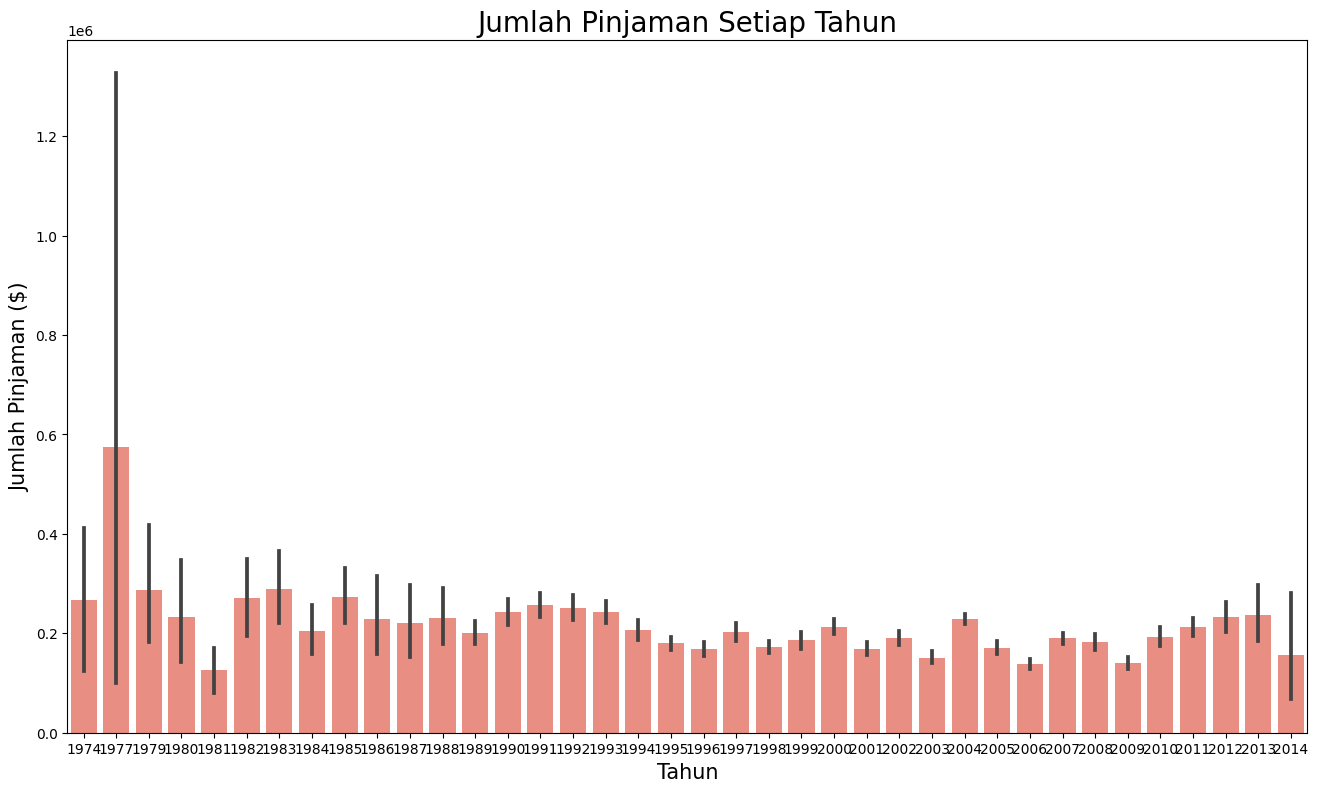

In [317]:
#Membuat plot jumlah pinjaman setiap tahunya
f, ax = plt.subplots(figsize=(16,9))
sns.barplot(x="ApprovalFY", y="DisbursementGross", color='Salmon', data=data)
plt.title('Jumlah Pinjaman Setiap Tahun', fontsize=20)
plt.xlabel('Tahun', fontsize=15)
plt.ylabel('Jumlah Pinjaman ($)', fontsize=15)

In [318]:
data.DisbursementGross.describe()

count    2.856600e+04
mean     1.915605e+05
std      2.697843e+05
min      4.000000e+03
25%      3.500000e+04
50%      9.806600e+04
75%      2.330000e+05
max      6.296554e+06
Name: DisbursementGross, dtype: float64

Grafik di atas adalah jumlah pinjaman yang diberikan bank setiap tahunya kepada pengusaha. Dapan dilihat bahwa ada beberapa kali penurunan pada tahun 1994 dan 2007. Hal ini disebabkan pada tahun-tahun tersebut mengalama krisi global, sehingga bank akan mengurangi pinjaman kepada pengusaha. Untuk rata-rata pinjaman pertahunya sebesar $190.000–$200.000. Mari kitalihat lebih detail lagi berdasarkan sektor.

Text(0, 0.5, 'Nama Sektor')

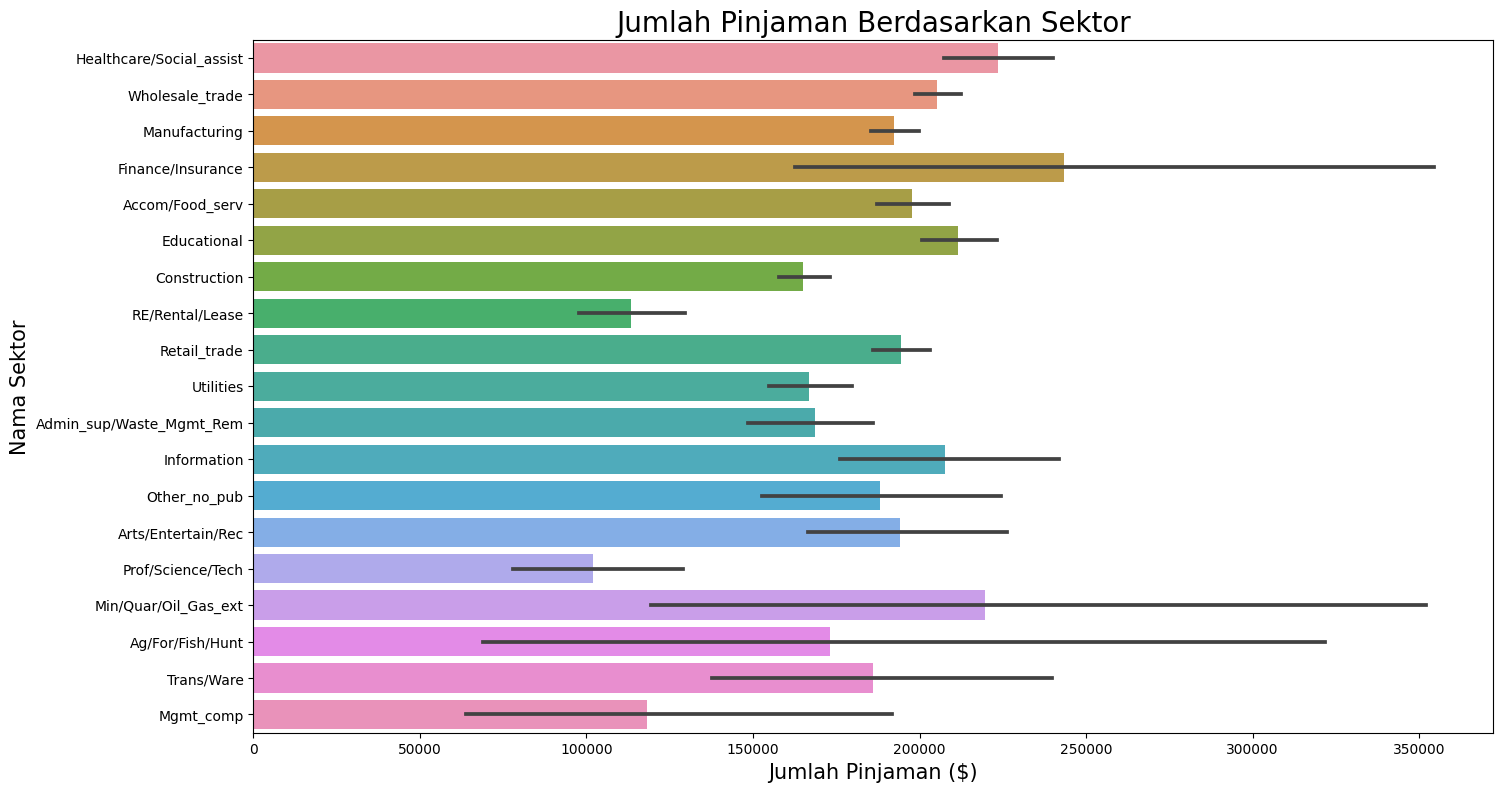

In [319]:
#Membuat plot jumlah pinjaman berdasarkan sektornya
f, ax = plt.subplots(figsize=(16,9))
sns.barplot(x="DisbursementGross", y="Sector_name", data=data)
plt.title('Jumlah Pinjaman Berdasarkan Sektor', fontsize=20)
plt.xlabel('Jumlah Pinjaman ($)', fontsize=15)
plt.ylabel('Nama Sektor', fontsize=15)

In [320]:
data.groupby('Sector_name')['DisbursementGross'].describe().style.highlight_max(color='green').highlight_min(color='blue')

,count,mean,std,min,25%,50%,75%,max
Sector_name,,,,,,,,
Accom/Food_serv,2149.000000,197704.578874,260920.560600,4000.000000,40000.000000,100000.000000,250000.000000,2000000.000000
Admin_sup/Waste_Mgmt_Rem,601.000000,168638.301165,239467.114824,5000.000000,25221.000000,77500.000000,180800.000000,2000000.000000
Ag/For/Fish/Hunt,7.000000,172967.142857,188934.928452,17000.000000,57737.000000,148000.000000,178200.000000,573896.000000
Arts/Entertain/Rec,284.000000,194130.570423,250543.064642,4000.000000,45225.000000,100000.000000,257234.250000,2000000.000000
Construction,3314.000000,165072.191913,231692.600341,4000.000000,30000.000000,80000.000000,187375.000000,2000000.000000
Educational,2295.000000,211676.201307,296282.903350,4000.000000,42052.000000,101750.000000,250000.000000,3259000.000000
Finance/Insurance,68.000000,243469.720588,409860.928770,4000.000000,35125.750000,110266.500000,294250.000000,3000000.000000
Healthcare/Social_assist,1097.000000,223511.089335,282765.247786,5000.000000,48000.000000,116500.000000,275000.000000,2000000.000000
Information,216.000000,207730.625000,257633.091652,5959.000000,55000.000000,134000.000000,224625.000000,1507000.000000


Seperti kita lihat grafik dan tabel di atas, paling banyak yang mendapatkan pinjaman adalah sektor Management Of Companies & Enterprise dan terendah adalah Public Administration. Jumlah data terbanyak ada pada sektro Retail Trade dan paling sedikit pada sektor Public Administration, sehingga untuk analisa seterusnya kemungkinan paling besar dan kecil pada setiap grafik adalah dua sektor tersebut.

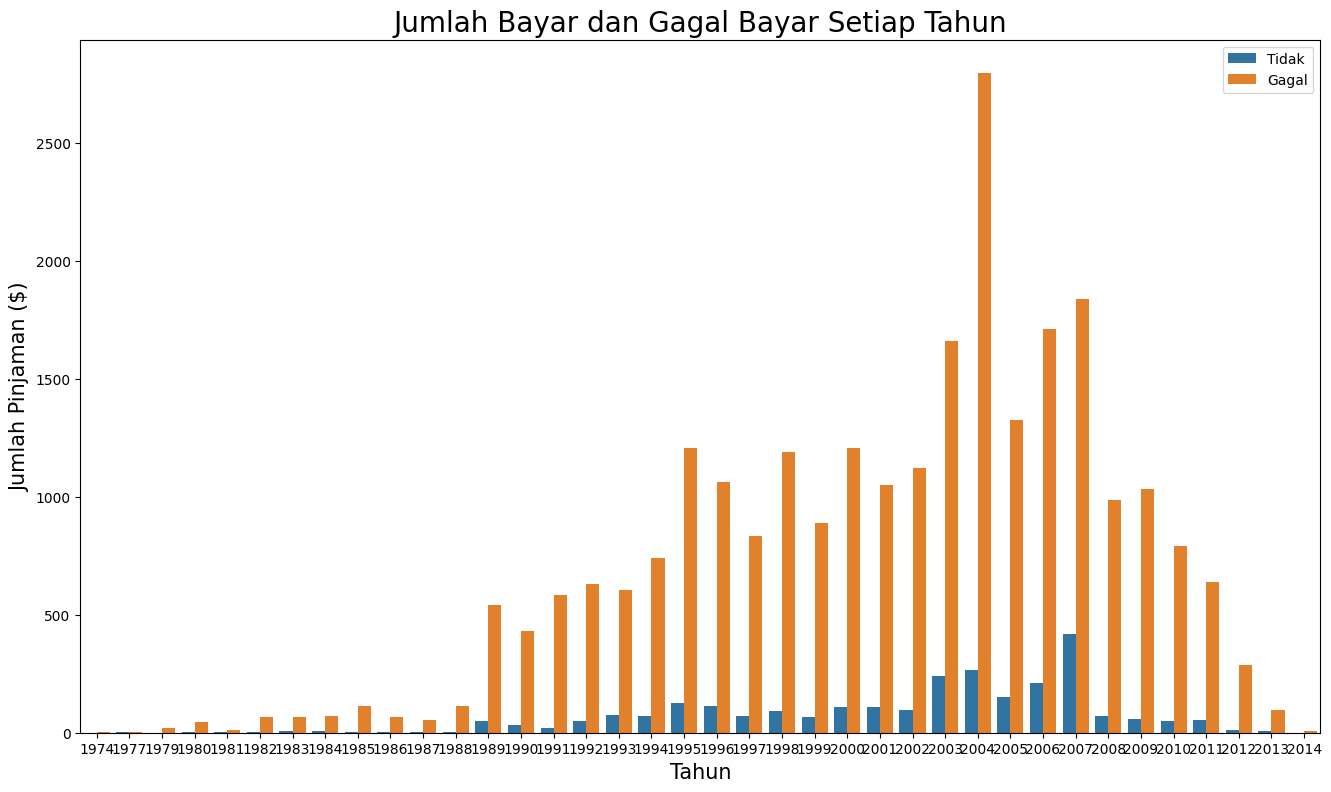

In [321]:
#Melihat jumlah yang bayar dan gagal bayar setiap tahunya
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(x="ApprovalFY", data=data,hue='MIS_Status')
plt.title('Jumlah Bayar dan Gagal Bayar Setiap Tahun', fontsize=20)
plt.xlabel('Tahun', fontsize=15)
plt.ylabel('Jumlah Pinjaman ($)', fontsize=15)
plt.legend(["Tidak", "Gagal"],loc='upper right')

Bisa kita lihat bawha ada peningkatan gagal bayar mulai tahun 2006-2008 hal ini sesuai dengan keadaan ekonomi dunia saat itu yang mengalami resesi global, sehingga banyak sekali pengusaha atau bisnis yang sulit untuk melakukan pembayaran.

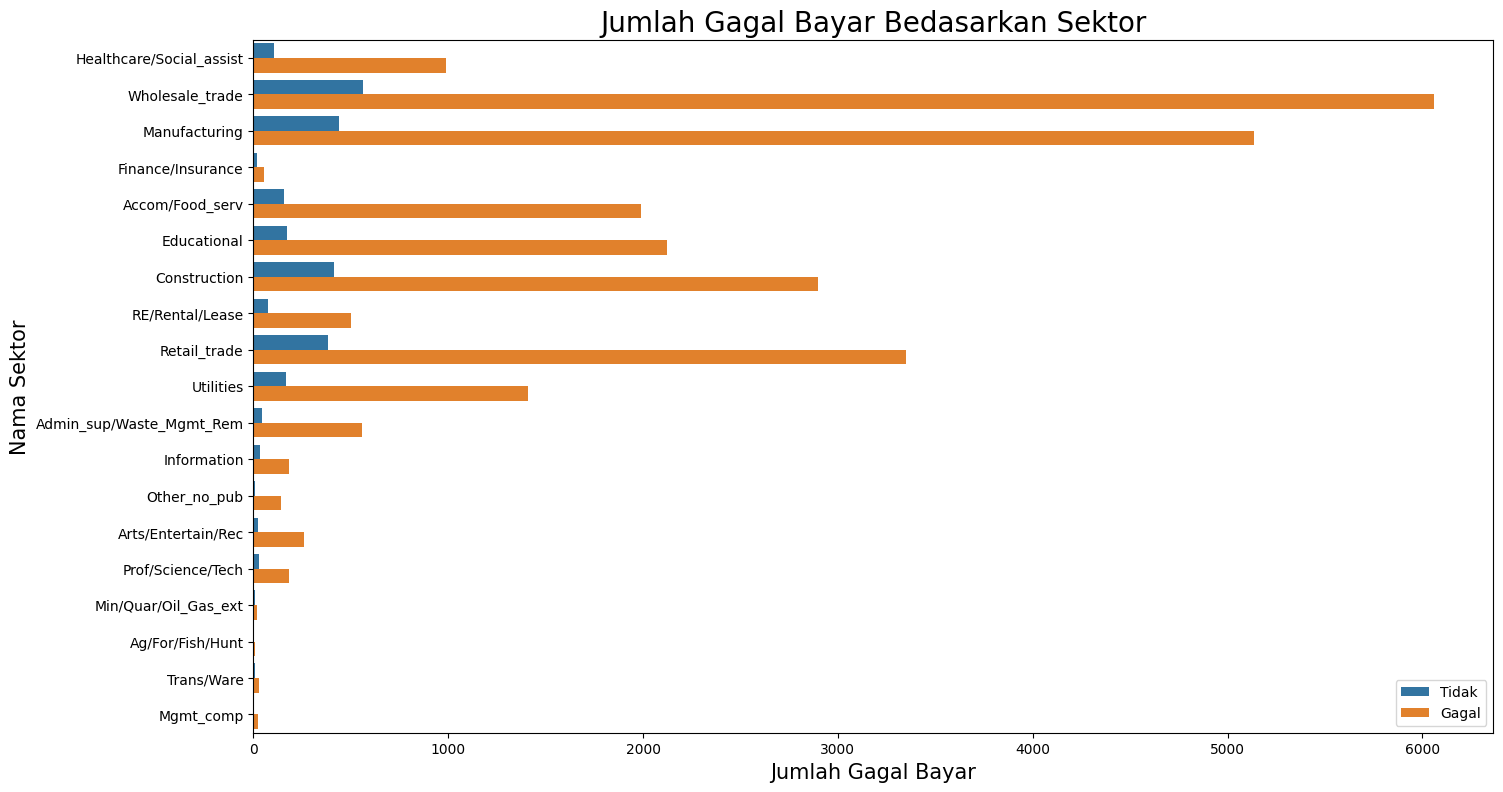

In [322]:
#Melihat jumlah yang bayar & gagal bayar pada setiap sektor
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(y="Sector_name", hue="MIS_Status", data=data)
plt.title('Jumlah Gagal Bayar Bedasarkan Sektor', fontsize=20)
plt.xlabel('Jumlah Gagal Bayar', fontsize=15)
plt.ylabel('Nama Sektor', fontsize=15)
plt.legend(["Tidak", "Gagal"],loc='lower right')

In [323]:
pd.DataFrame(data.groupby('Sector_name')['MIS_Status'].value_counts()).unstack(level=1).style.highlight_max(color='green').highlight_min(color='blue')

Seperti yang kita ketahui bawha data terbanyak adala Retail Trade, sehingga sektor yang paling banyak baik dalam bayar dan gagal bayar adalah sektor tersebut.

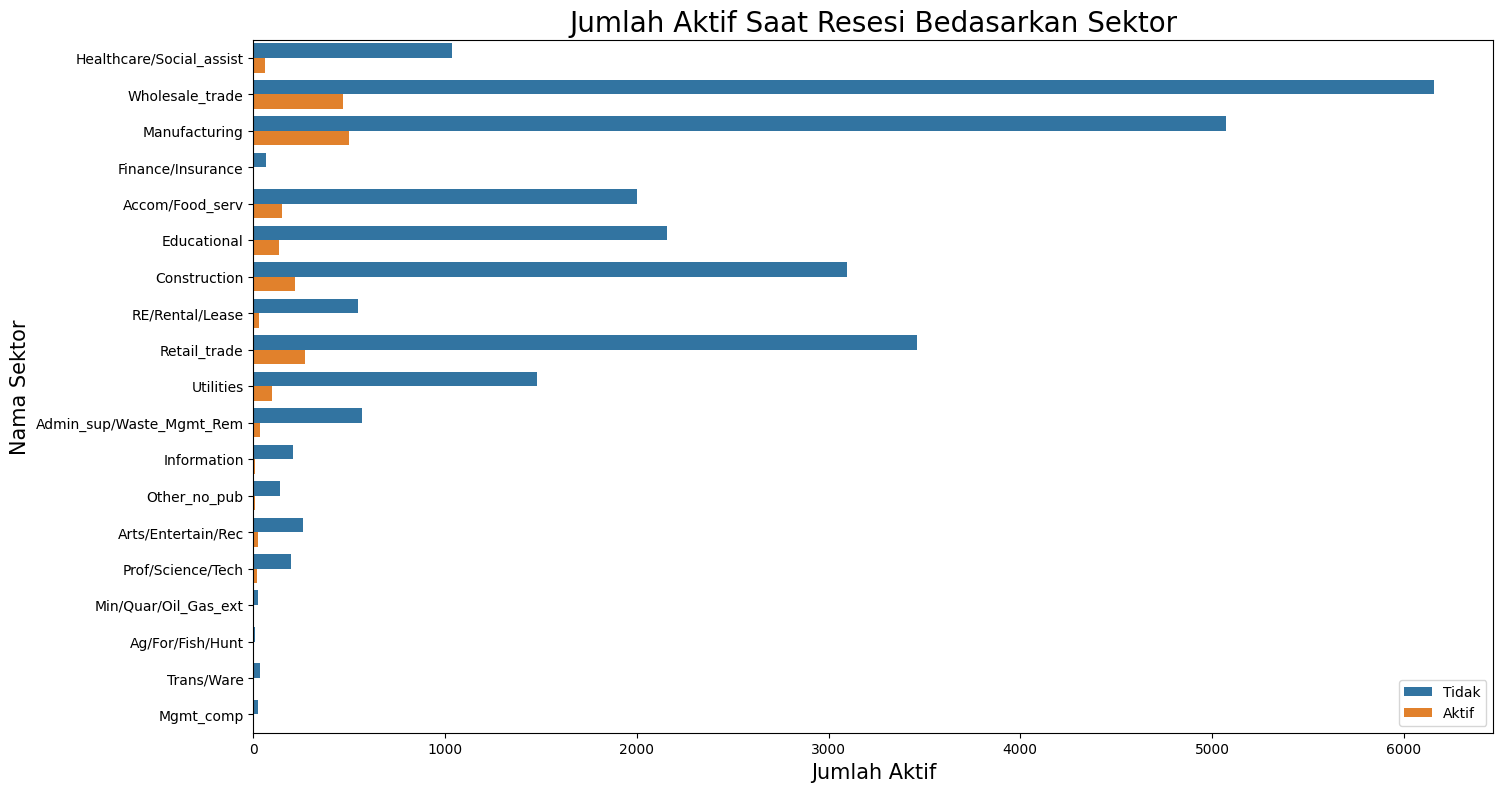

In [324]:
#Membuat plot sektor yang aktif saat resesi global tahun 2008
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(y="Sector_name", hue="Recession", data=data)
plt.title('Jumlah Aktif Saat Resesi Bedasarkan Sektor', fontsize=20)
plt.xlabel('Jumlah Aktif', fontsize=15)
plt.ylabel('Nama Sektor', fontsize=15)
plt.legend(["Tidak", "Aktif"],loc='lower right')

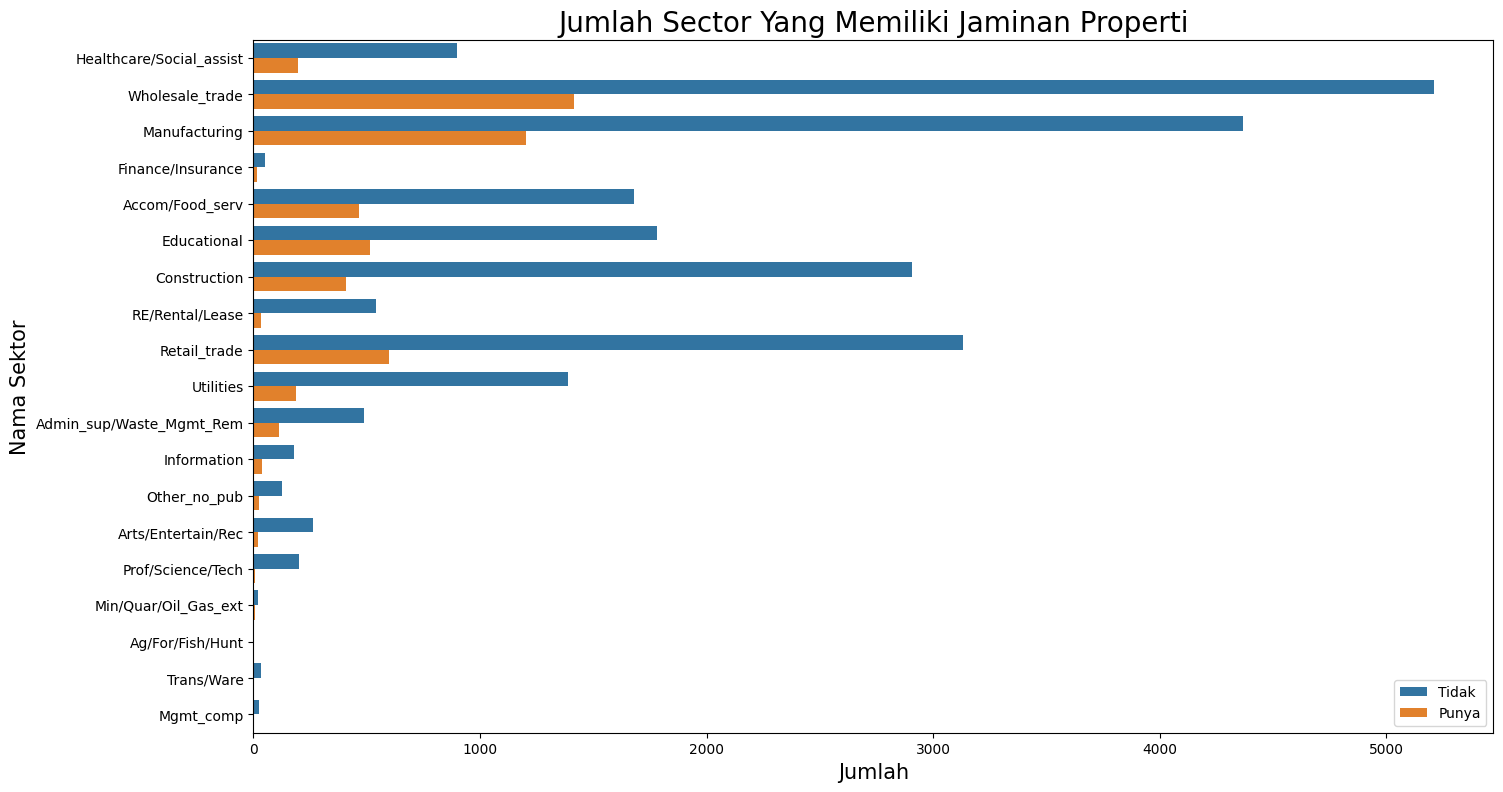

In [325]:
#Meliat sektor mana saja yang memiliki jaminan properti
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(y="Sector_name", hue="RealEstate", data=data)
plt.title('Jumlah Sector Yang Memiliki Jaminan Properti', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)
plt.ylabel('Nama Sektor', fontsize=15)
plt.legend(["Tidak", "Punya"],loc='lower right')
plt.show()

In [326]:
#Melihat lebih detail sektor dengan jaminan properti
pd.DataFrame(data.groupby('Sector_name')['RealEstate'].value_counts()).unstack(level=1).style.highlight_max(color='green').highlight_min(color='blue')

In [327]:
# #Melihat lama pinjaman
# f, ax = plt.subplots(figsize=(16,9))
# sns.boxplot(data['Term'])
# plt.title('Lama Pinjaman', fontsize=20)
# plt.xlabel('Bulan', fontsize=15)

In [328]:
#Melihat detail pinjaman
data['Term'].describe() 

count    28566.000000
mean       109.698243
std         89.280316
min          0.000000
25%         55.000000
50%         82.000000
75%        122.000000
max        325.000000
Name: Term, dtype: float64

Text(0, 0.5, 'Nama Sektor')

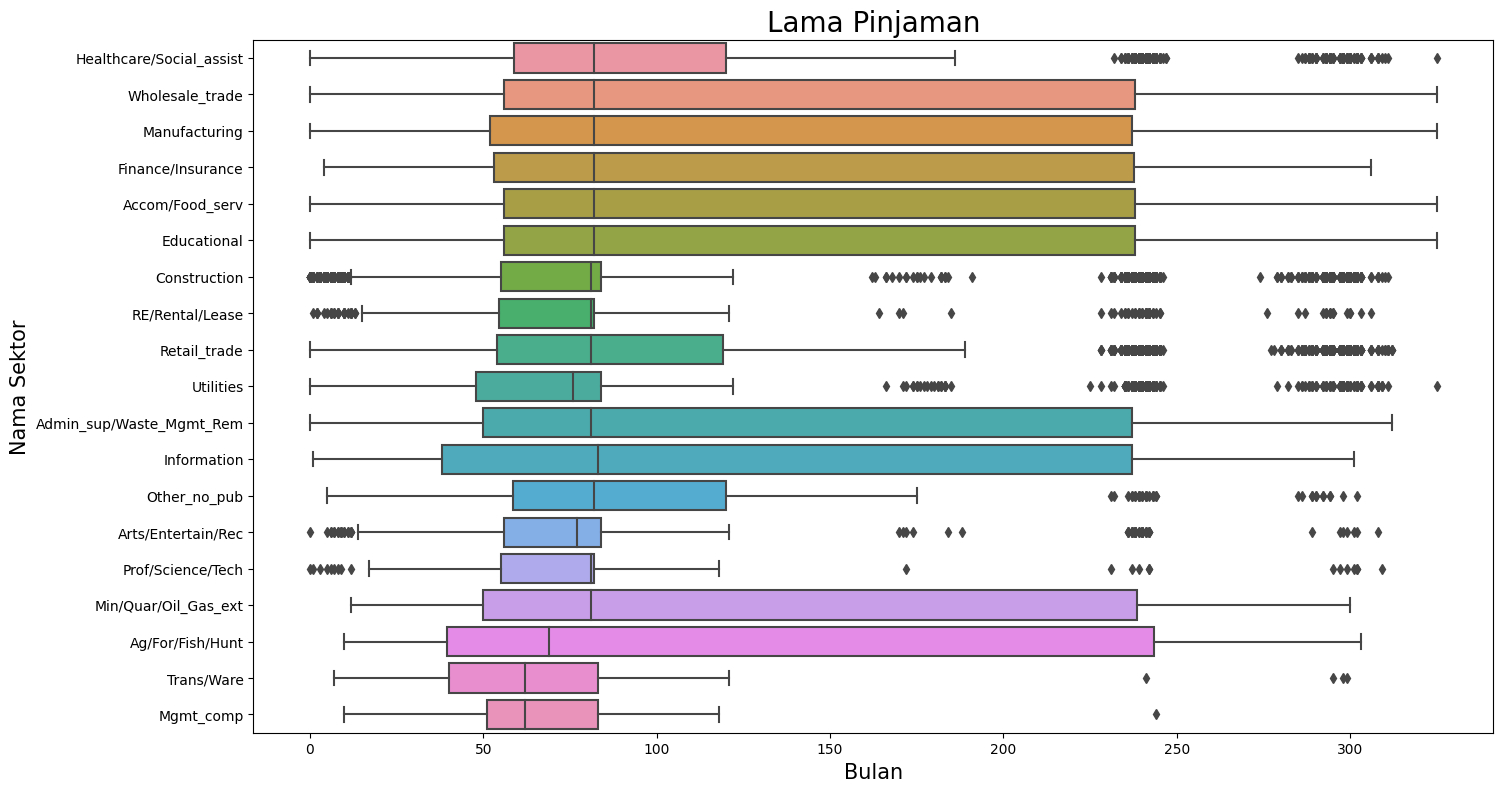

In [329]:
#Melihat pinjaman berdasarkan sektor
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x="Term", y="Sector_name", data=data)
plt.title('Lama Pinjaman', fontsize=20)
plt.xlabel('Bulan', fontsize=15)
plt.ylabel('Nama Sektor', fontsize=15)

In [330]:
#Detail pinjaman berdasarkan sektor
data.groupby('Sector_name')['Term'].describe().style.highlight_max(color='green').highlight_min(color='blue')

,count,mean,std,min,25%,50%,75%,max
Sector_name,,,,,,,,
Accom/Food_serv,2149.000000,119.302932,93.198927,0.000000,56.000000,82.000000,238.000000,325.000000
Admin_sup/Waste_Mgmt_Rem,601.000000,110.106489,92.666312,0.000000,50.000000,81.000000,237.000000,312.000000
Ag/For/Fish/Hunt,7.000000,135.428571,123.492047,10.000000,39.500000,69.000000,243.500000,303.000000
Arts/Entertain/Rec,284.000000,91.140845,71.129911,0.000000,56.000000,77.000000,84.000000,308.000000
Construction,3314.000000,96.106216,78.421710,0.000000,55.000000,81.000000,84.000000,311.000000
Educational,2295.000000,118.858824,93.479458,0.000000,56.000000,82.000000,238.000000,325.000000
Finance/Insurance,68.000000,115.470588,96.553051,4.000000,53.250000,82.000000,237.500000,306.000000
Healthcare/Social_assist,1097.000000,113.492252,86.337165,0.000000,59.000000,82.000000,120.000000,325.000000
Information,216.000000,110.319444,95.940993,1.000000,38.000000,83.000000,237.000000,301.000000


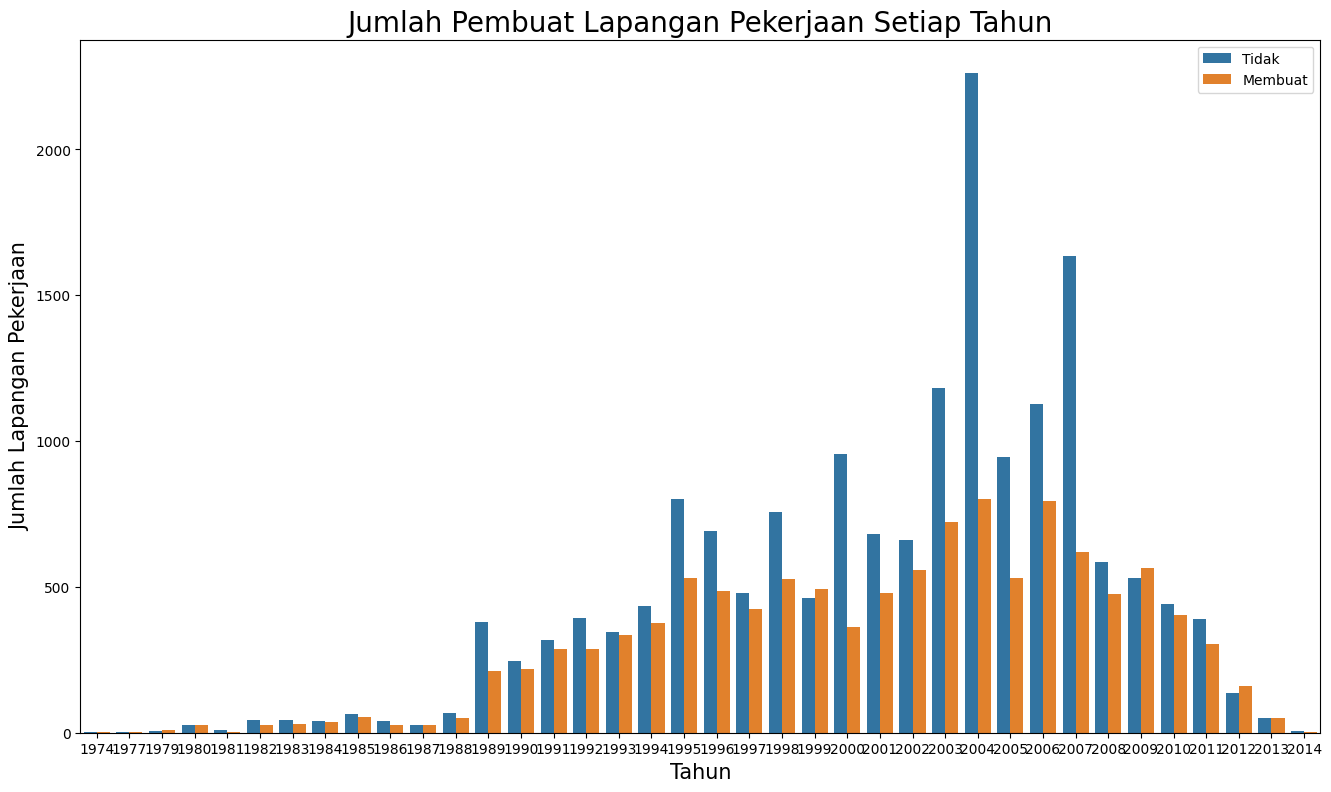

In [331]:
#Melihat jumlah lapangan pekergja setiap tahun
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(x="ApprovalFY", data=data,hue='Is_CreatedJob')
plt.title('Jumlah Pembuat Lapangan Pekerjaan Setiap Tahun', fontsize=20)
plt.xlabel('Tahun', fontsize=15)
plt.ylabel('Jumlah Lapangan Pekerjaan', fontsize=15)
plt.legend(["Tidak", "Membuat"],loc='upper right')

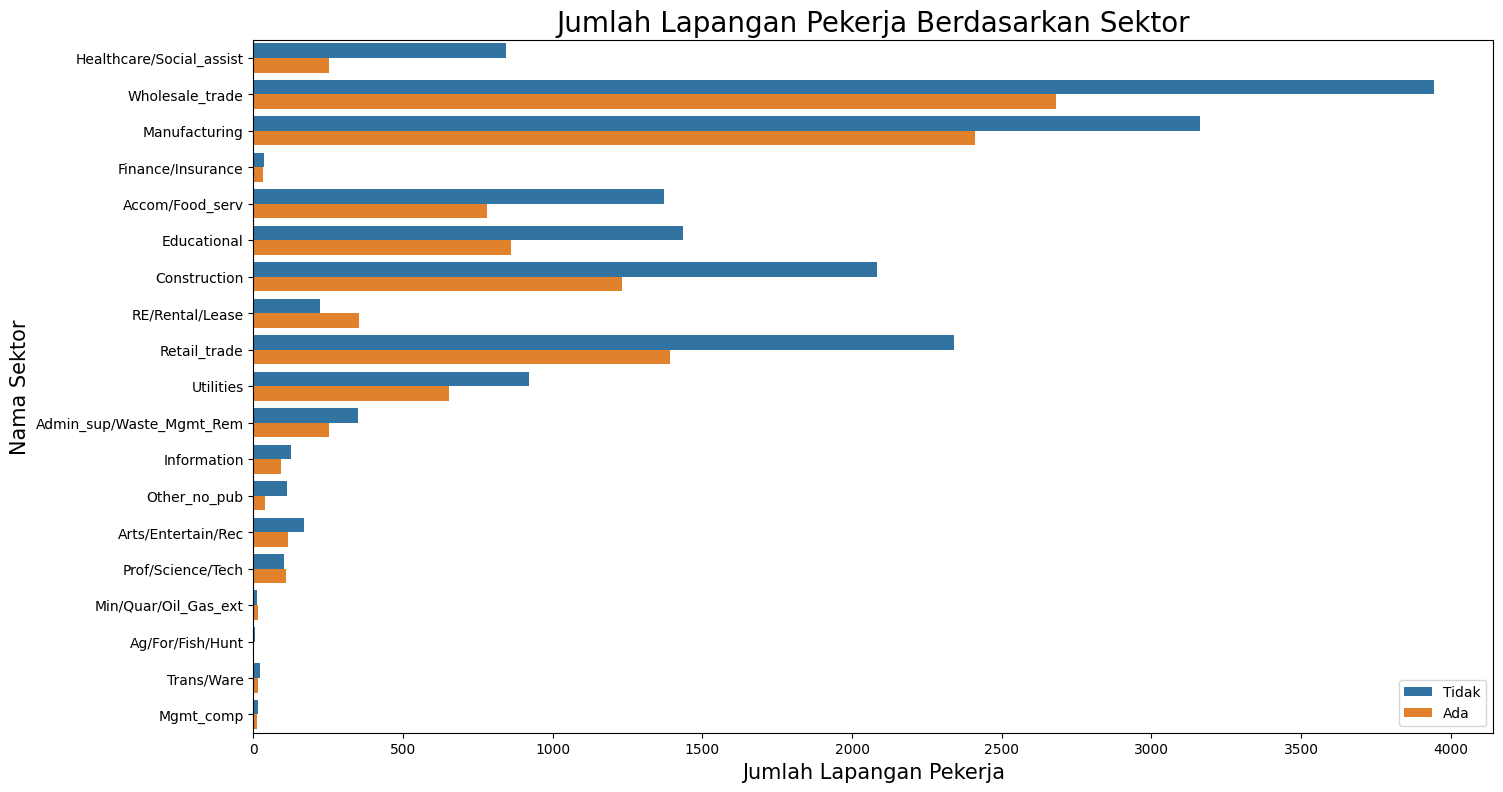

In [332]:
#Jumlah lapangan kera berdasrkan sektor
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(y="Sector_name", hue="Is_CreatedJob", data=data)
plt.title('Jumlah Lapangan Pekerja Berdasarkan Sektor', fontsize=20)
plt.xlabel('Jumlah Lapangan Pekerja', fontsize=15)
plt.ylabel('Nama Sektor', fontsize=15)
plt.legend(["Tidak", "Ada"],loc='lower right')

In [333]:
#Detail Setiap sektor lapangan kerja
pd.DataFrame(data.groupby('Sector_name')['Is_CreatedJob'].value_counts()).unstack(level=1).style.highlight_max(color='green').highlight_min(color='blue')

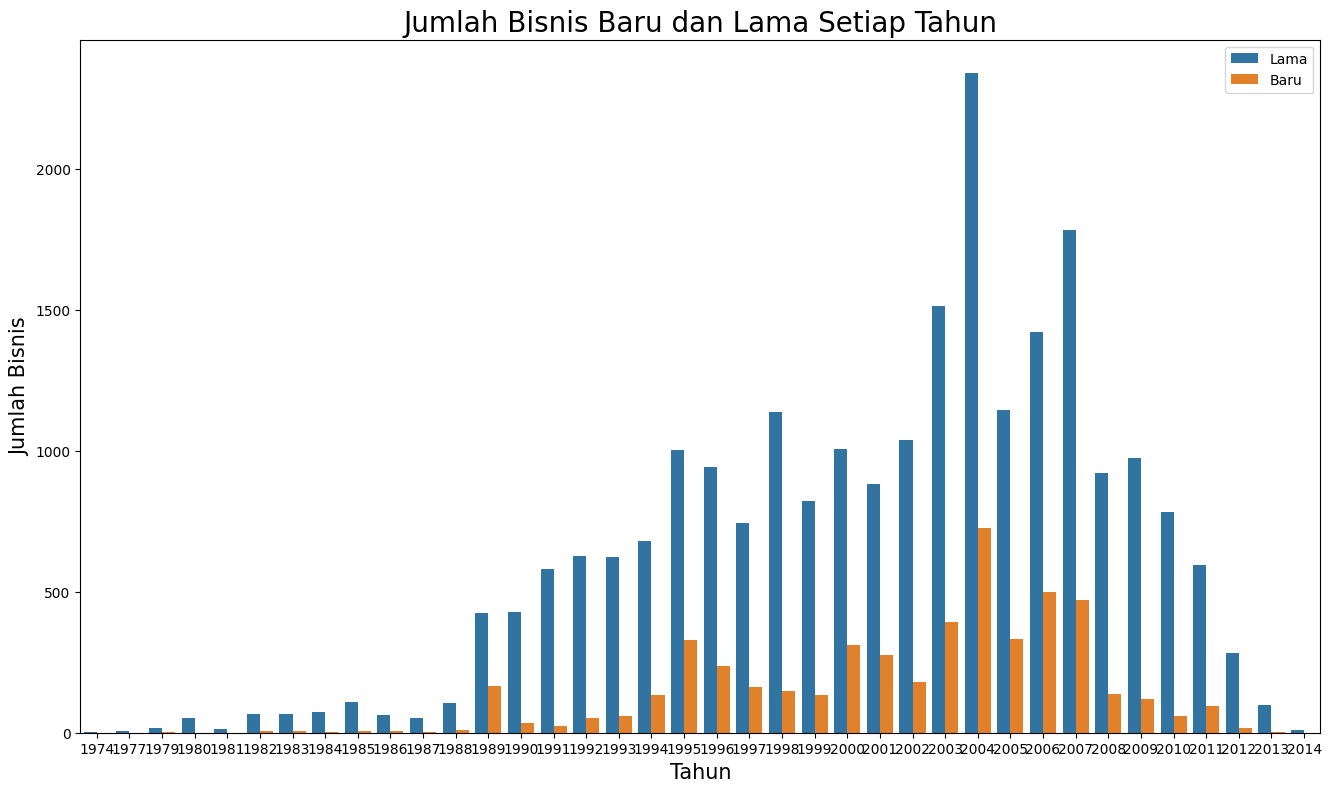

In [334]:
#Melihat jumlah bisnis baru dan lama yang ikut SBA setiap tahun
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(x="ApprovalFY", data=data,hue='NewExist')
plt.title('Jumlah Bisnis Baru dan Lama Setiap Tahun', fontsize=20)
plt.xlabel('Tahun', fontsize=15)
plt.ylabel('Jumlah Bisnis', fontsize=15)
plt.legend(["Lama", "Baru"],loc='upper right')

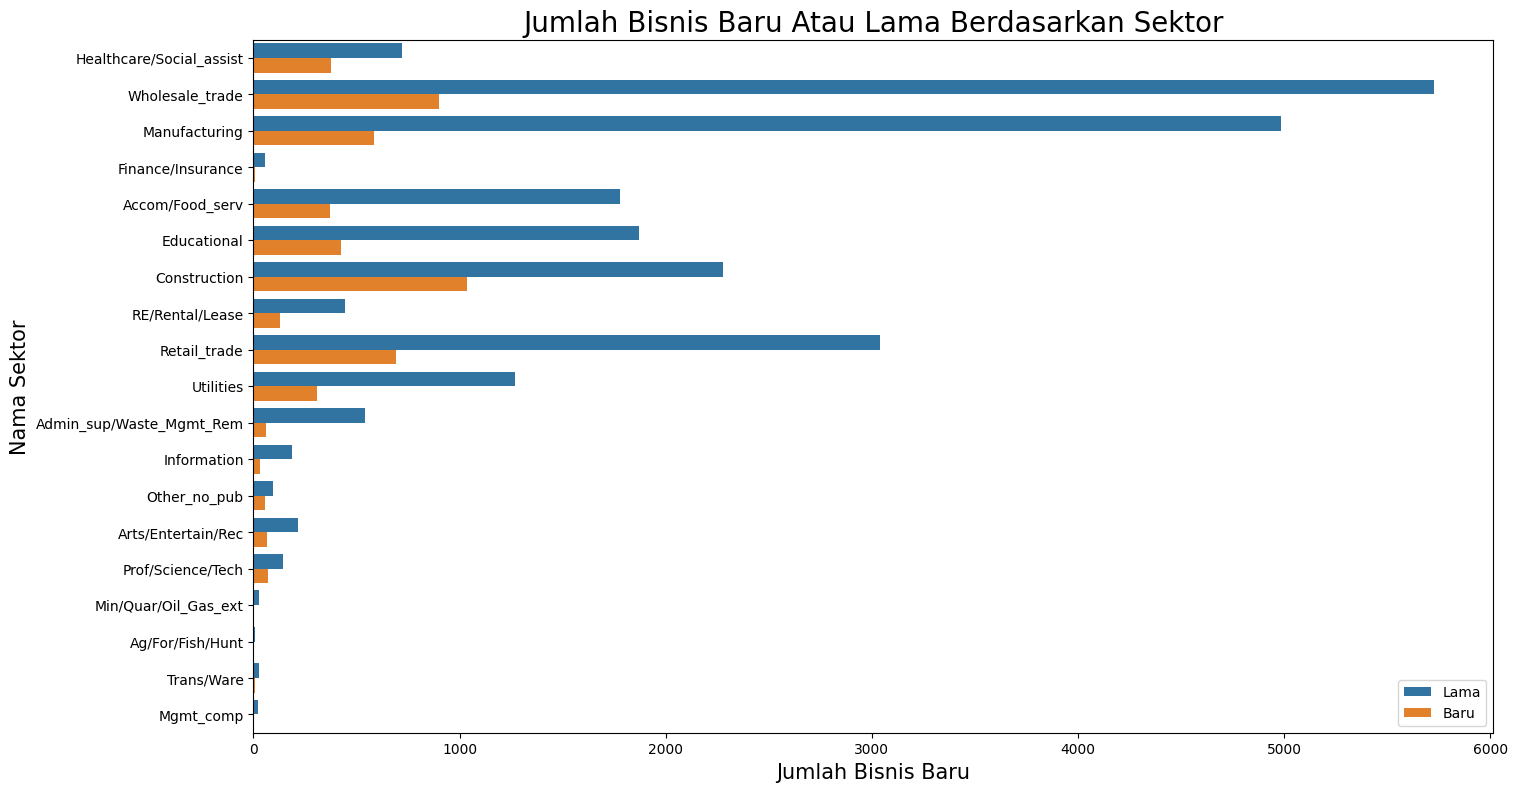

In [335]:
#Membuat plot Jumla bisnis baru dan lama berdasarkan sektor
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(y="Sector_name", hue="NewExist", data=data)
plt.title('Jumlah Bisnis Baru Atau Lama Berdasarkan Sektor', fontsize=20)
plt.xlabel('Jumlah Bisnis Baru', fontsize=15)
plt.ylabel('Nama Sektor', fontsize=15)
plt.legend(["Lama", "Baru"],loc='lower right')

In [336]:
#Detail Jumla bisnis baru dan lama berdasarkn sektor
pd.DataFrame(data.groupby('Sector_name')['NewExist'].value_counts()).unstack(level=1).style.highlight_max(color='green').highlight_min(color='blue')

##  **2.4 Handling Outliers**

Kita akan melihat apakah ada outlier di data kita dan akan kita coba untuk menanganinya agar tidak teradi sala interpretasi terhadap target varibel kita. Namun kita perlu cek juga apakah outlier ini sala input atau memang dia anomali.

In [337]:
#kita akan membuang kolom-kolom yang danggap tidak penting
# kolom LoanNr_ChkDgt tidak penting karena hanya id dari peminjam sudah digantikan dengan index
# kolom City, State, UrbanRural dan ZIP tidak perlu karena sudah kita ubah menjadi state rate
# kolom bank dan bank satet juga tidak terlalu penting
# kolom NAICS karen sudah digantikan dengan Sector_rate
# kolom ApprovalDate dan ApprovalFY karena hanya pencataan tanggal saja
# kolom Term dihapus karena sudah digantikan dengan RealEstate
# kolom UrbanRural karena tidak mempengaruhi target
# kolom LowDoc karena suda ada Disbursement Gross, LowDoc hanya dikelompokkan saja secara administartif
# kolom Active dan DaysTerm karena sudah digantikan dengan Recession
# kolom ind_code karena sudah ada Secator_rate
# kolom ChgOffDate karena dia sebernya sama dengan MIS_Status
# kolom DisbursementDate karena hanya tanggan pembayaran
# kolom SBA_Appv karena sudah digatikan dengan Portion_SBA_Bank
# kolom DisbursementDate sudah tidak digunakan lagi
# kolom Sector_name suda tidak digunakan lagi
data = data.drop(axis =1, columns = ['City','State', 'UrbanRural', 'LowDoc',
                                    'ApprovalDate', 'ApprovalFY', 'SBA_Appv','DisbursementDate', 
                                     'Sector_name',])

In [338]:
#Kita akan menggunakan Inter Quartile Range untuk menangani ouliers
#Menentukan Limit
def limit(i):
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3 - Q1
    
    #menentukan upper limit biasa dan upper limit ekstim
    lower_limit = data[i].quantile(0.25) - (IQR * 1.5)
    lower_limit_extreme = data[i].quantile(0.25) - (IQR * 3)
    upper_limit = data[i].quantile(0.75) + (IQR * 1.5)
    upper_limit_extreme = data[i].quantile(0.75) + (IQR * 3)
    print('Lower Limit:', lower_limit)
    print('Lower Limit Extreme:', lower_limit_extreme)
    print('Upper Limit:', upper_limit)
    print('Upper Limit Extreme:', upper_limit_extreme)

#Mengitung persen outliers dari data    
def percent_outliers(i):
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3 - Q1
    
    #menentukan upper limit biasa dan upper limit ekstim
    lower_limit = data[i].quantile(0.25) - (IQR * 1.5)
    lower_limit_extreme = data[i].quantile(0.25) - (IQR * 3)
    upper_limit = data[i].quantile(0.75) + (IQR * 1.5)
    upper_limit_extreme = data[i].quantile(0.75) + (IQR * 3)
    #melihat persenan outliers terhadap total data
    print('Lower Limit: {} %'.format(data[(data[i] >= lower_limit)].shape[0]/ data.shape[0]*100))
    print('Lower Limit Extereme: {} %'.format(data[(data[i] >= lower_limit_extreme)].shape[0]/data.shape[0]*100))
    print('Upper Limit: {} %'.format(data[(data[i] >= upper_limit)].shape[0]/ data.shape[0]*100))
    print('Upper Limit Extereme: {} %'.format(data[(data[i] >= upper_limit_extreme)].shape[0]/data.shape[0]*100))

Text(0.5, 0, 'Jumlah')

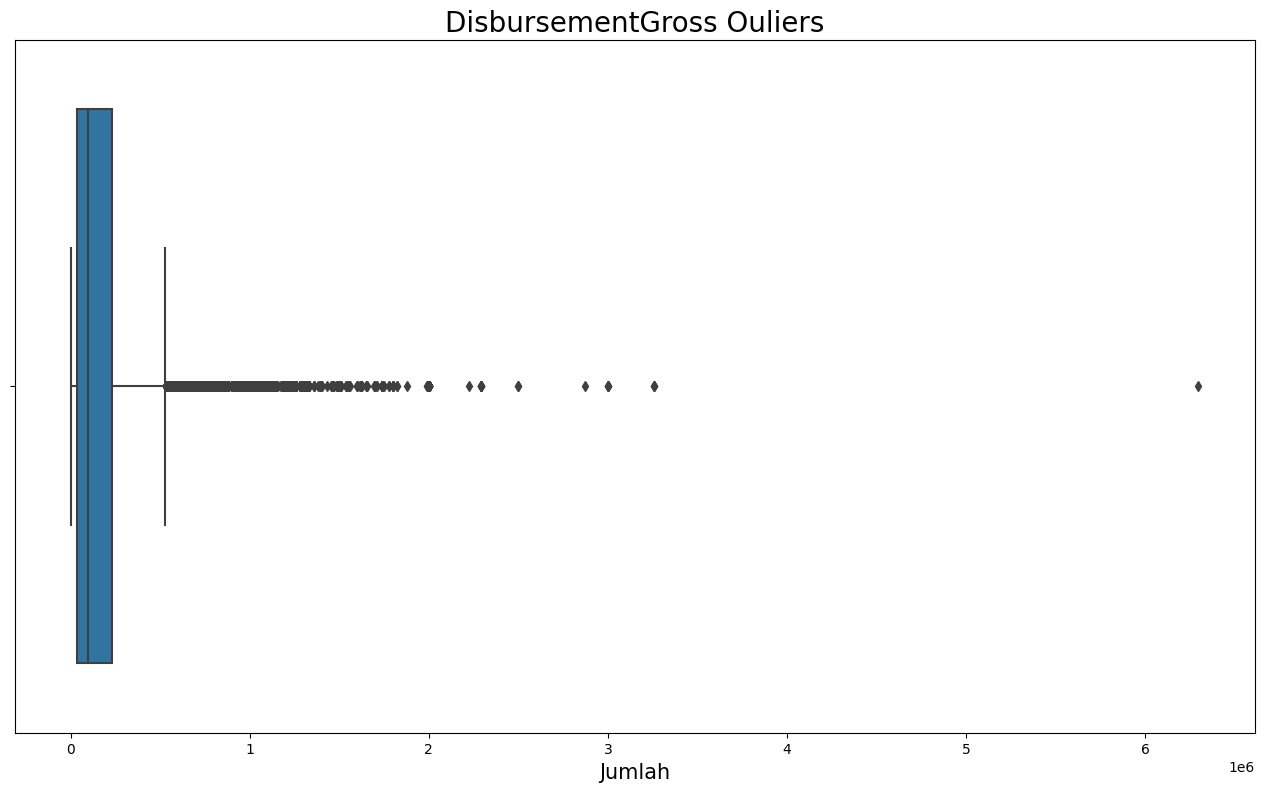

In [339]:
#Kita cek kolom DisbursemntGross
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=data['DisbursementGross'])
plt.title('DisbursementGross Ouliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [340]:
#kita akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit('DisbursementGross'))
print('-'*50)
print(percent_outliers('DisbursementGross'))

Lower Limit: -262000.0
Lower Limit Extreme: -559000.0
Upper Limit: 530000.0
Upper Limit Extreme: 827000.0
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 8.804172792830638 %
Upper Limit Extereme: 3.798221662115802 %
None


In [341]:
#karena terdapat 10 % dari jumlah data yang kita punya, maka saya coba merubah datanya dengan menggunakan
#log transformation, karena jika ouliers dihilangkan sangat banyak sekali data yang hilang (10%)
data['DisbursementGross'] = np.log(data['DisbursementGross'])
data['DisbursementGross'].skew()

-0.13479752286477353

In [342]:
#kita akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit('DisbursementGross'))
print('-'*50)
print(percent_outliers('DisbursementGross'))

Lower Limit: 7.619567752357118
Lower Limit Extreme: 4.776032164242686
Upper Limit: 15.202329320662269
Upper Limit Extreme: 18.0458649087767
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 0.003500665126374011 %
Upper Limit Extereme: 0.0 %
None


In [343]:
#ternyata masih ada sekitar 1% outliers, karena jumlahnya terbilang kecil, maka kita drop saja
outliers1_drop = data[(data['DisbursementGross'] > 14.9)].index
data.drop(outliers1_drop, inplace=True)

Text(0.5, 0, 'Jumlah')

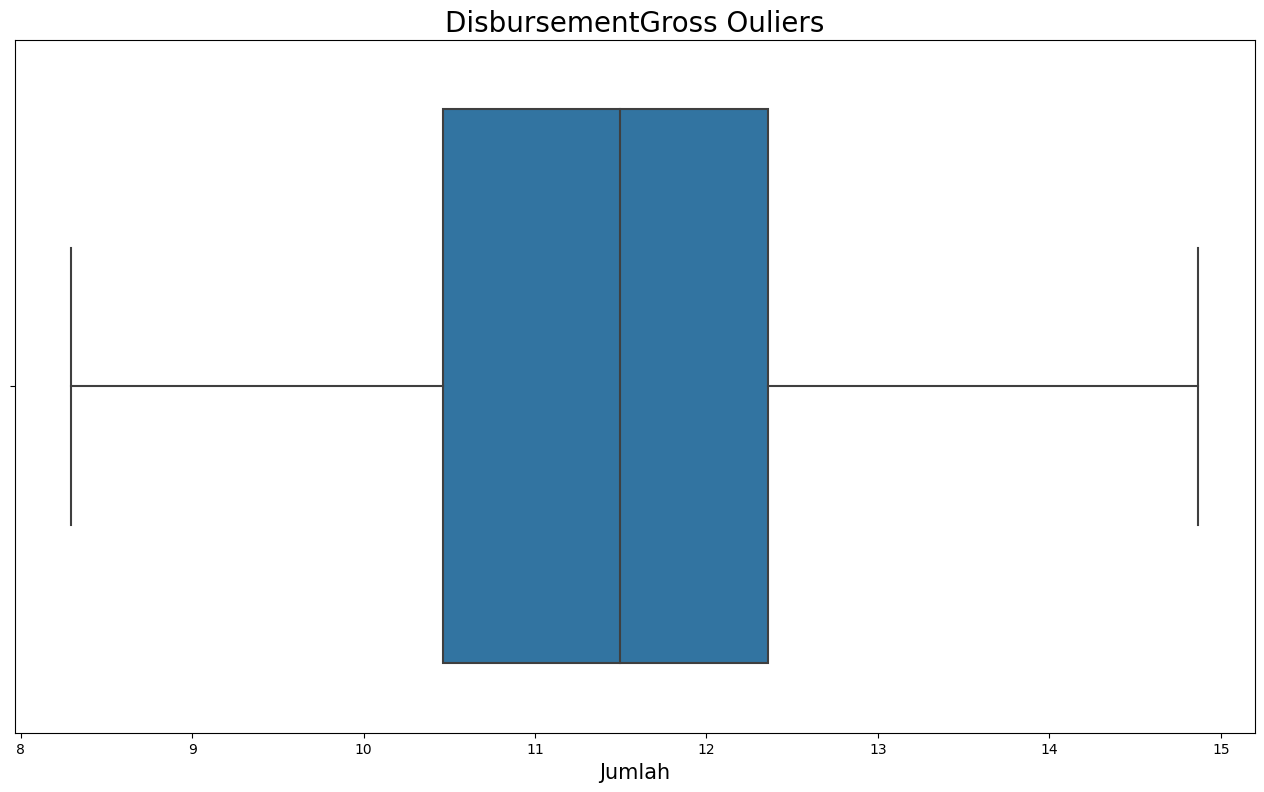

In [344]:
#kita cek lagi apakah masiha ada outliers
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=data['DisbursementGross'])
plt.title('DisbursementGross Ouliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

Text(0.5, 0, 'Jumlah')

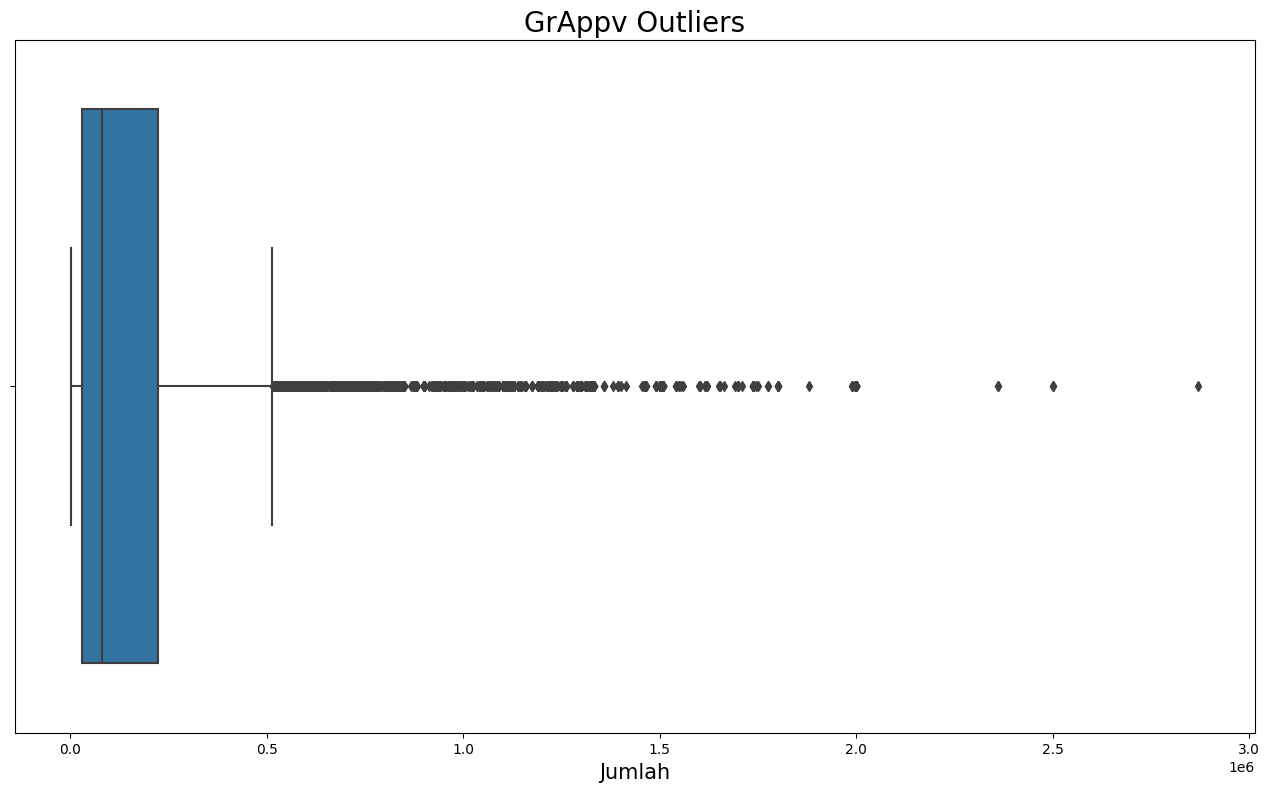

In [345]:
#kita cek pada kolom GrAppv apakah ada outliers
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=data['GrAppv'])
plt.title('GrAppv Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [346]:
#kita akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit('GrAppv'))
print('-'*50)
print(percent_outliers('GrAppv'))

Lower Limit: -263250.0
Lower Limit Extreme: -555000.0
Upper Limit: 514750.0
Upper Limit Extreme: 806500.0
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 9.562994607465509 %
Upper Limit Extereme: 3.8553119966384197 %
None


In [347]:
data['GrAppv'] = np.log(data['GrAppv'])
data['GrAppv'].skew()

-0.06025182408391131

In [348]:
#kita akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit('GrAppv'))
print('-'*50)
print(percent_outliers('GrAppv'))

Lower Limit: 7.171757839978473
Lower Limit Extreme: 4.085856313700203
Upper Limit: 15.400828576720524
Upper Limit Extreme: 18.486730102998795
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 0.0 %
Upper Limit Extereme: 0.0 %
None


In [349]:
#ternyata masih ada sekitar 1% outliers, karena jumlahnya terbilang kecil, maka kita drop saja
outliers2_drop = data[(data['GrAppv'] < 7.5)].index
data.drop(outliers2_drop, inplace=True)

Text(0.5, 0, 'Jumlah')

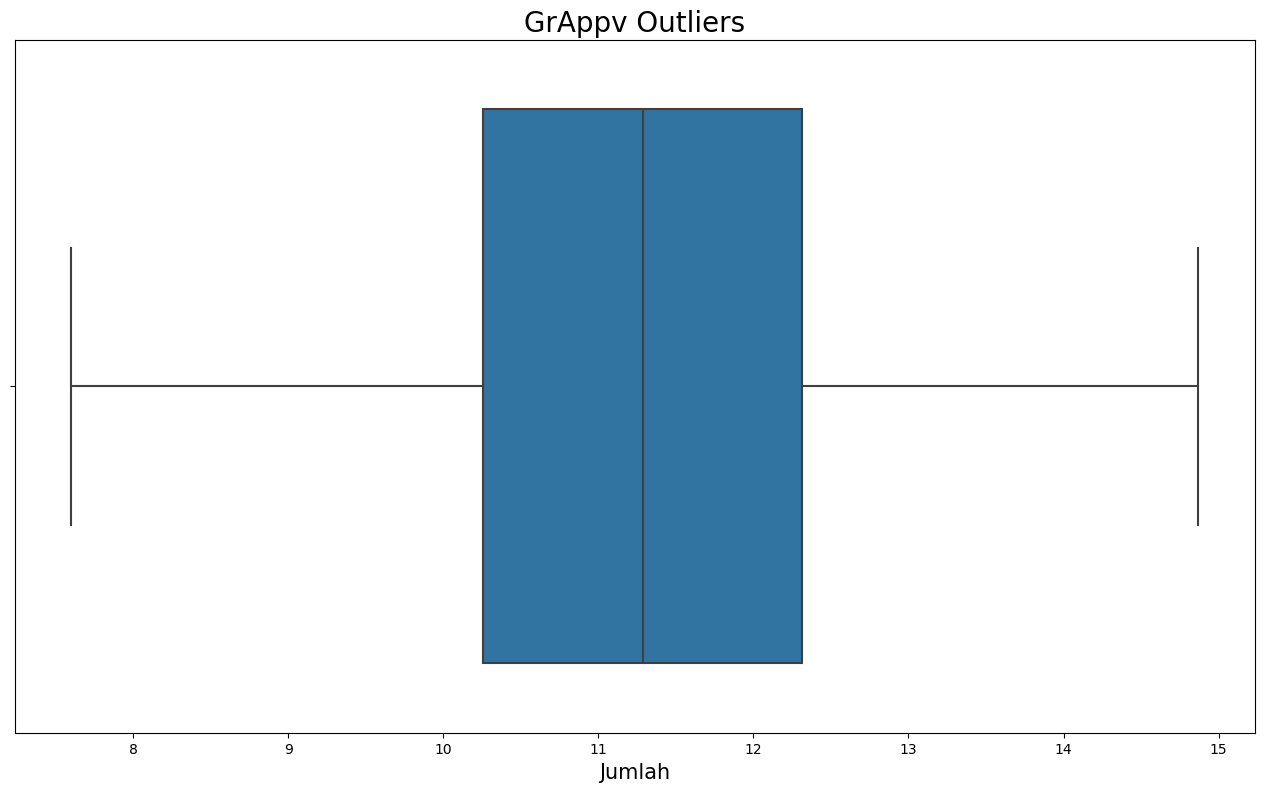

In [350]:
#kita cek lagi pada kolom GrAppv apakah masih ada outliers
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=data['GrAppv'])
plt.title('GrAppv Outliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

Text(0.5, 0, 'Jumlah')

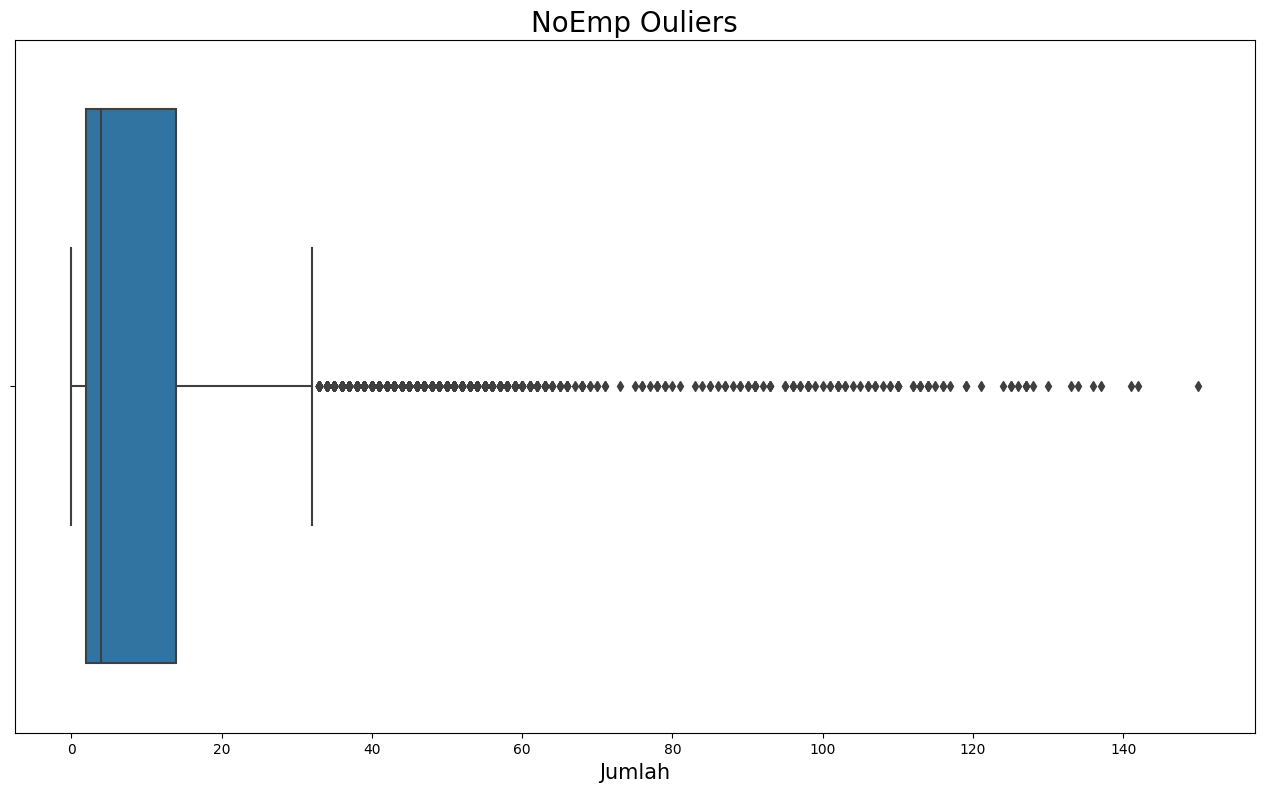

In [351]:
#kita cek ouliers pada kolom NoEmp
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=data['NoEmp'])
plt.title('NoEmp Ouliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

In [352]:
#kita akan cek limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit('NoEmp'))
print('-'*50)
print(percent_outliers('NoEmp'))

Lower Limit: -16.0
Lower Limit Extreme: -34.0
Upper Limit: 32.0
Upper Limit Extreme: 50.0
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 7.0523145878562925 %
Upper Limit Extereme: 2.461656978780027 %
None


In [353]:
#pada kolom NoEmp, terdapat iput 0, aka saya anggap ini kesalahan, input, karena tidak mungkin sebuah perusahaan
#tidak memiliki karyawan
wrong_input = data[(data['NoEmp'] == 0)].index
data.drop(wrong_input, inplace=True)

In [354]:
#melakukan boxcox transformasi karena semua metode tela saya coba namun ini yang paling baik hasilnya
data['NoEmp']= stats.boxcox(data['NoEmp'])[0]

In [355]:
data['NoEmp'].skew()

0.04308628481533458

In [356]:
#kita akan cek lagi limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit('NoEmp'))
print('-'*50)
print(percent_outliers('NoEmp'))

Lower Limit: -0.8253707345066836
Lower Limit Extreme: -2.667228206654726
Upper Limit: 4.08624919122143
Upper Limit Extreme: 5.928106663369473
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 0.0 %
Upper Limit Extereme: 0.0 %
None


In [357]:
#ternyata masih ada sekitar 0.02% outliers, karena jumlahnya terbilang kecil, maka kita drop saja
outliers3_drop = data[(data['NoEmp'] > 3.3)].index
data.drop(outliers3_drop, inplace=True)

Text(0.5, 0, 'Jumlah')

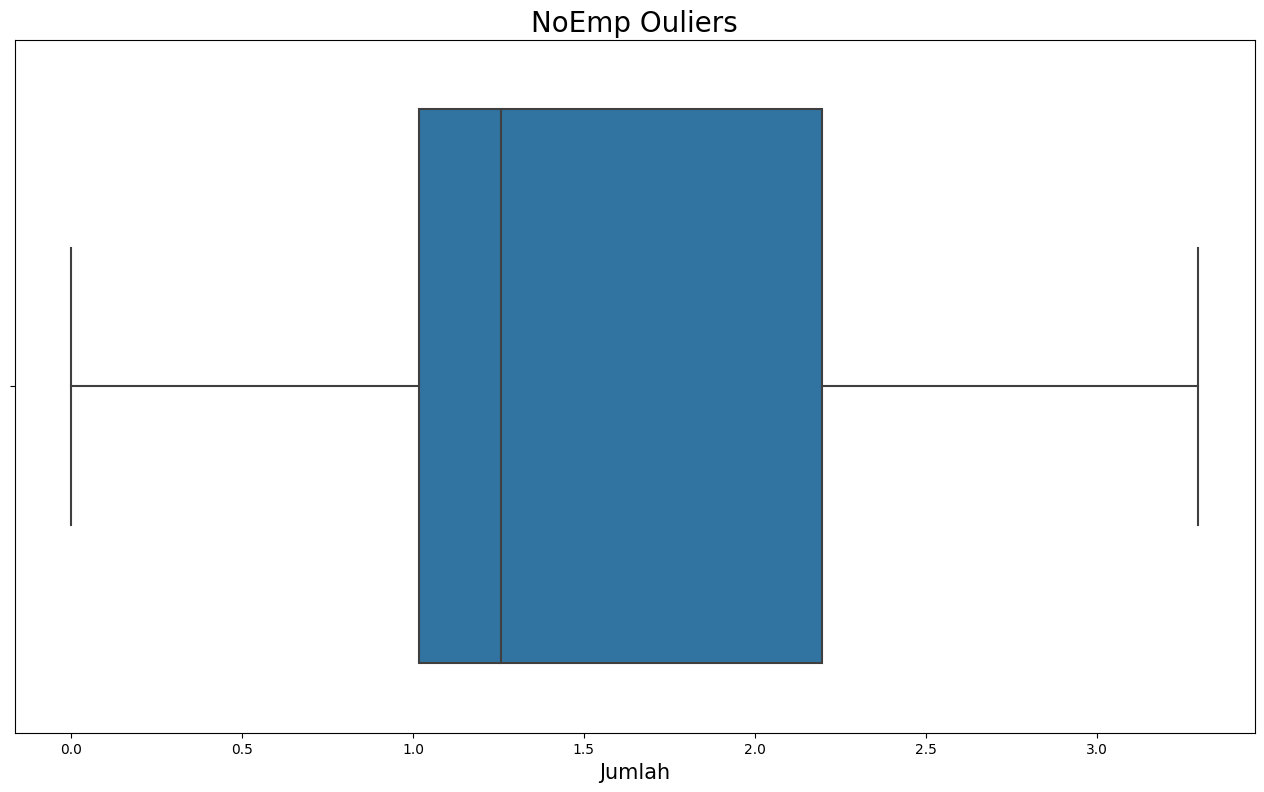

In [358]:
#kita cek ouliers lagi pada kolom NoEmp
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=data['NoEmp'])
plt.title('NoEmp Ouliers', fontsize=20)
plt.xlabel('Jumlah', fontsize=15)

Text(0.5, 0, 'Bulan')

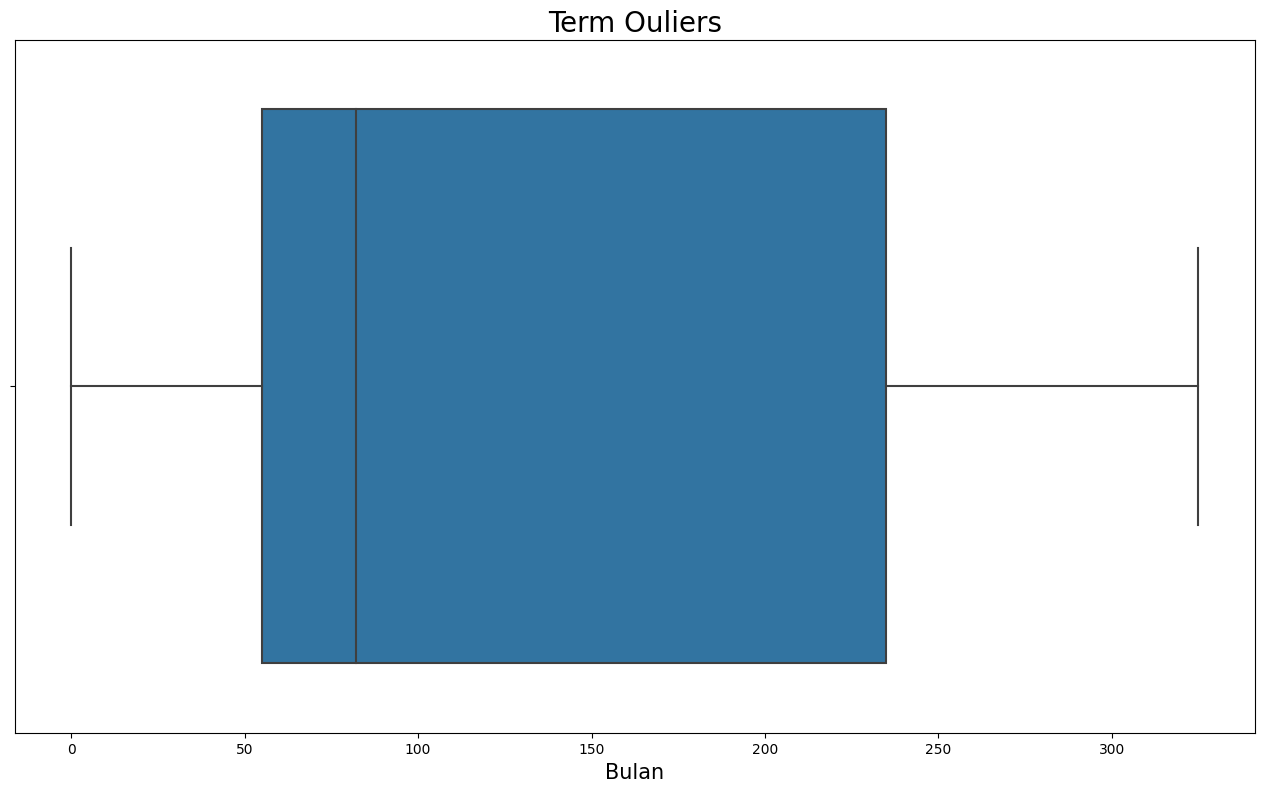

In [359]:
#kita cek ouliers pada kolom Term
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=data['Term'])
plt.title('Term Ouliers', fontsize=20)
plt.xlabel('Bulan', fontsize=15)

In [360]:
#Karena terdapat data yang lama pinajamanya 0 bulan dan 43 tahun 
#karena tidak mungkin ada waktu 0 dan 569 bulan (43 tahun) 
#sedangkan pengambilan data yang kita punya hanya dari tahun 1987–2010 (23 tahun),
#sehingga minimal 5 tahun (75 bulan) atau maksimal 23 tahun (276 bulan)
wrong_input_2 = data[(data['Term'] < 75)].index
wrong_input_3 = data[(data['Term'] > 276)].index
data.drop(wrong_input_2, inplace=True)
data.drop(wrong_input_3, inplace=True)

Text(0.5, 0, 'Bulan')

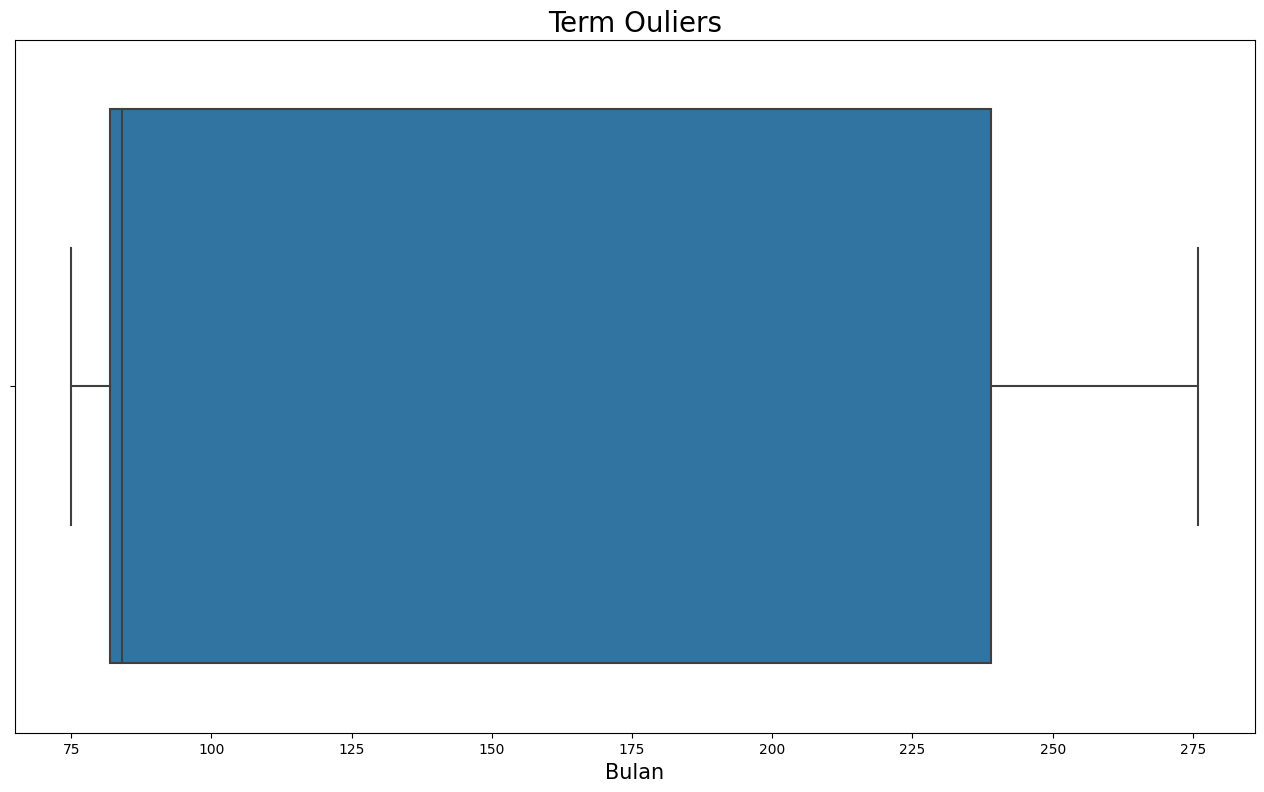

In [361]:
#kita cek lagi ouliers pada kolom Term
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(x=data['Term'])
plt.title('Term Ouliers', fontsize=20)
plt.xlabel('Bulan', fontsize=15)

In [362]:
#kita akan cek lagi limit outliers dan berapa persen dari data kita yang melebihi limit tersebut
print(limit('Term'))
print('-'*50)
print(percent_outliers('Term'))

Lower Limit: -153.5
Lower Limit Extreme: -389.0
Upper Limit: 474.5
Upper Limit Extreme: 710.0
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 0.0 %
Upper Limit Extereme: 0.0 %
None


In [363]:
#kita tidak akan drop outlier ini, karena selain jumlanya banyak (18%) ini belum tentu salah input, karena memang
#beberapa industri bisa mengambil jangka waktu pinjaman yang lama seperti oil & gas tau mining

## **2.5 Feature Selection**

Tahap ini kita akan memilih atau mencari feature mana saja yang paling relefan dengan target kita. Saya suda mencoba dengan menggunakan KBest dan Feature Importance dan saya juga tidak memnggunkan corelation coeficient karena target variabelnya dan ada beberapa independen variabel yang kategorikal. Namun setela dimasukkan ke dalam model yang paling bagus adalah Fetaure Importance.

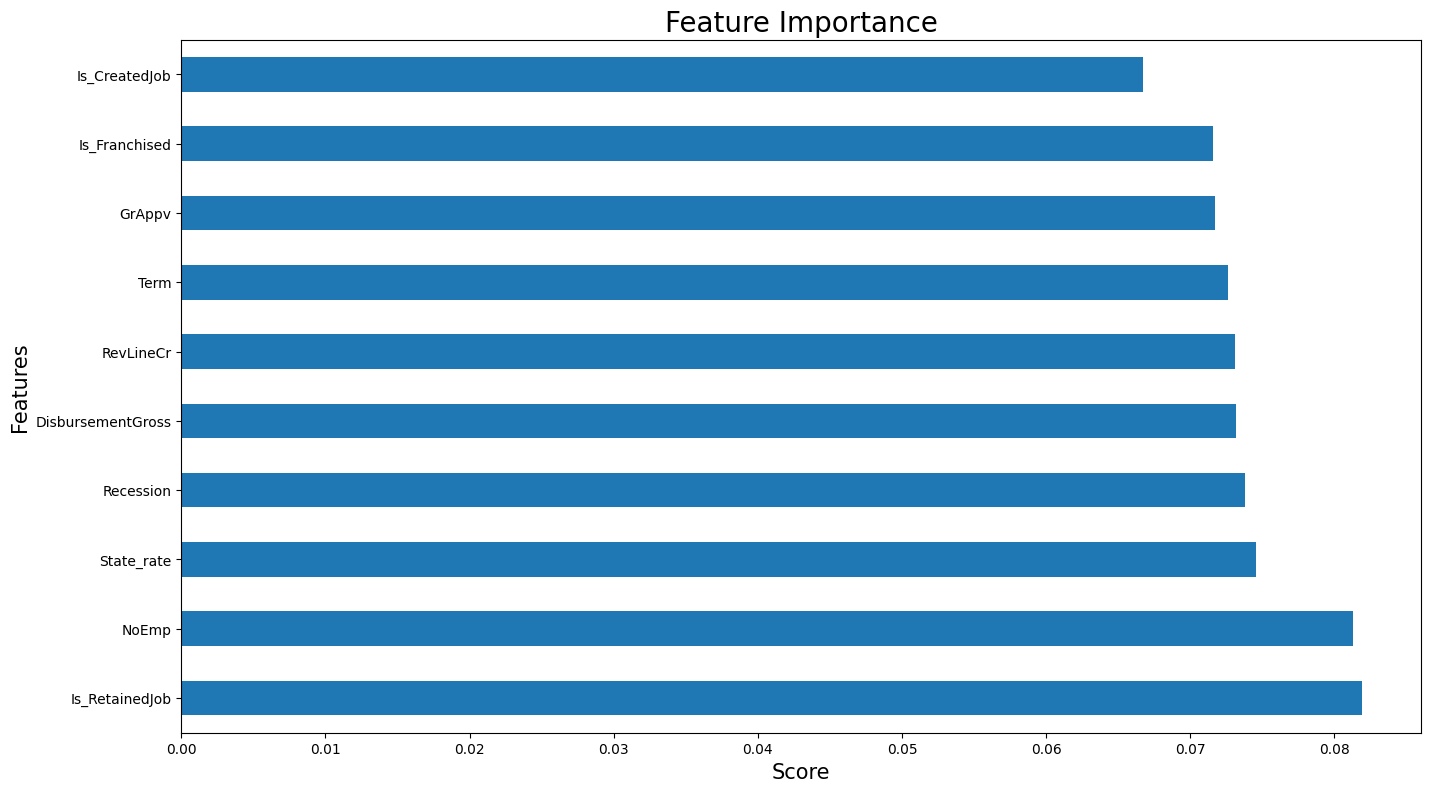

In [364]:
#karena data memiliki jumlah input yang sangat banyak, maka saya akan menggunakan teknik feature importance pada fetaure selection
#kita akan memisahkan dulu independen dan dependen featurenya
#data = data.reset_index(drop=True) #reset index dulu biar urut indexnya
y = data['MIS_Status']
X = data.drop(columns=['MIS_Status'], axis=1)

#kita coba menggunakan fetaure importance pada model XGboost
model = XGBClassifier()
model.fit(X,y)

#Kita visualisasi feature yang penting-penting
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
f, ax = plt.subplots(figsize=(16,9))
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance', fontsize=20)
plt.ylabel('Features', fontsize=15)
plt.xlabel('Score', fontsize=15)
plt.show()

Bisa diliat bahwa ini adala 10 variabel yang memiliki pengaru terhadap target kitag:
1. Term (Lama Pinjaman) = sangat masuk akal sekali ini menjadi yang tertinggi karena jika sebuah perusahaan meminjam dengan jangka waktu yang lama, kemungkinan untuk kembali mengembaklikanya akan lebih besar dikarenan bunga yang diberikan akan semakin kecil, sehingga memudahkan perusahaan untuk membayarnya dan kestabilan secara ekonomi secara nasional maupun internasional yang tidak terlalu berdampak yang akhirnya membuat perusaaan mengurangi kemungkinan untuk gagal bayar.


2. RevLineCr = Revolving Line of credit ini adalah ketika suda minjam terus minjam lagi. Bisa dikatakan bahwa jika dia bisa melakukan Revolving maka pihak bank sudah menilai bahwa perusahaan ini mampu dalam membayar pinjamanya sehingga diberikan pinjaman lagi. Jadi jika perusahaan ini Revolving Line Of Credit juga membuat perusahaan mengurangi kemungkinan untuk gagal bayar.


3. Portion_SBA_Bank = Ini merupakan seberapa banyak pihak SBA berani untuk memberikan jaminan dari pijamana yang diberikan oleh Bank. Semakin besar persenenanya otomatis pihak SBA cukup yakin dengan perusahaan tersebut untuk tidak gagal bayar.


4. Is_RetainedJob = Apakah perusahaan memiliki karyawan tetap? Karena jika tidak, kemungkinan perusahaan tersebut belum stabil karena belum mampu untuk memiliki karyawan tetap. Jika belum stabil, maka kemungkinan untuk maksimal dalam bisnisnya juga belum, sehingga meningkatkan kemungkinan untuk gagal bayar.


5. DisbursementGross = Menjadi sala satu faktor yang penting juga karena jumlah pinjaman yang dibayarkan apakah ada penalti atau sesuai dengan pinjaman diawal, jika lebih maka kemungkinan dia ada penalti.


6. State_rate = Perlu diingat bahwa kebijakan setiap daera berbeda-beda dan juga ini dihitung dengan berapa rerata setiap daerah yang gagal bayar dari semua sektor, sehingga semakin tinggi maka semakin kemungkinan dia gagal bayar.


7. GrAppv = Merupakan jumlah pinjaman yang diberikan oleh bank. Kita tidak bisa melihat dari satu sisi ini saja karena dari pihak bank juga memiliki ukuran tersendiri. 


8. Recssion = Jika dia aktif ketika masa-masa sulit sperti resesi, maka kemungkinan bisnisnya stabil, karena pada saat susapun dia tetap aktif, sehingga kemungkinan untuk gagal bayarnya menjadi lebi kecil.


9. Sector_rate = seperti halnya State rate, setiap sektor juga memiliki default rate atau persentase kemungkinan gagal bayarnya masing-masing. Karena tidak mungkin bisa disamakan untuk sektor oil& gas, mining disamakan dengan Retail Trade karena resiko dan kestabilan dari bisnisnya berbeda-beda.


10. Is_CreatedJob =  Membuka lapangan pekerjaan menjadi perhitungan juga karena dengan membuka lapangan pekerjaan terlihat bahwa perusahaan tersebut berkembang secara operasional dengan meningkatnya karyawan yang direkrut, sehingga jika perusahaan tersebut berkembang maka akan memperkecil kemungkinan dalam gagal bayar.


Perlu menjadi catatan bahwa semua variabel ini tidak bisa dilihat hanya dari satu sisi belaka, namun ada kaitan antar variabel. Karena latar belakang saya bukan seoarang banking, ekonom ataupun keuangan maka saya menganalisa ini berdasarkan logika dan guideline yang disediakan SBA. Perlu ada seorang dari business domain yang lebih mampu menjelaskan variabel-variabel ini terhadap kemungkinan gagal bayar.

In [365]:
#Berdasarkan feature selection diatas, kita akan pilih, feature-feature tersebut dan membuang
#feature-feature yang tidak relefan dengan target
data = data[['RevLineCr', 'Term', 'Portion_SBA_Bank', 'GrAppv', 'State_rate', 'DisbursementGross',
            'Is_RetainedJob', 'Sector_rate', 'Recession', 'Is_CreatedJob', 'MIS_Status']]
data.shape

(12920, 11)

 ## **2.6 Imbalance Dataset**
 
Karena ini adalah problem klasifikasi dan target variabel pada dataset yang kita miliki ini perbandingan yang sangat jau kerena persentase yang gagal bayar pasti lebih sedikit dibandingkan dengan yang berhasil, sehingga kita perlu menangani hal ini agar ketika nanti masuk ke dalam model tidak teradi bias karena terjadinya perbedaan ration apda target variabel.

In [366]:
#Kita cek ratio target variabel
print(data.MIS_Status.value_counts())
print('-'*50)
print('MIS_Status (0): {} %'.format(data[(data['MIS_Status'] == 0)].shape[0]/data.shape[0]*100))
print('MIS_Status (1): {} %'.format(data[(data['MIS_Status'] == 1)].shape[0]/data.shape[0]*100))

1    11868
0     1052
Name: MIS_Status, dtype: int64
--------------------------------------------------
MIS_Status (0): 8.142414860681114 %
MIS_Status (1): 91.85758513931889 %


In [367]:
# #Visualisasi Imbalance Dataset Sebelum Dibenahi
# sns.countplot("MIS_Status",data=data)

bisa dilihat bahwa target variabel kita imbalance atau tidak seimbang, 0 (Tidak Default): 94.3% dan 1(Default): 5.7% sehingga kita akan menangani masalah ini, karena jika tidak model akan lebih cenderung memprediksi 0 karena lebih banyak dalam jumlah

In [368]:
#pertama kita akan membagi data menjadi train dan test, namun perlu diingat, jika target data kita imbalance
#sehingga kita membagi data di traindan testnya harus sesuai, jadi tidak boleh dalam pembagian datanya ada yang 
#hanya berisi 0 atau yang mayoritas aja, makanya kita menggunakan stratify=y
y = data['MIS_Status']
X = data.drop(columns=['MIS_Status'], axis=1)
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=27, stratify=y) #jangan lupa untuk stratify

In [369]:
# X_train のデータタイプと形状の確認
print("X_train type:", type(X_train))
print("X_train shape:", X_train.shape)

# y_train のデータタイプと形状の確認
print("y_train type:", type(y_train))
print("y_train shape:", y_train.shape)

# X_train と y_train の最初の数行を表示（numpy.ndarray の場合）
print("X_train first few rows:\n", X_train[:5])
print("y_train first few values:", y_train[:5])

X_train type: <class 'numpy.ndarray'>
X_train shape: (9690, 10)
y_train type: <class 'pandas.core.series.Series'>
y_train shape: (9690,)
X_train first few rows:
 [[-0.4670957  -0.80281756  0.50739009 -1.07800649 -1.41536014 -1.20326533
   1.09096367  0.6199957  -0.21542524 -0.80404546]
 [-0.4670957   1.30656444 -1.2258959   0.1636652  -1.41536014  0.27773019
   1.09096367  0.6199957  -0.21542524  1.24371077]
 [-0.4670957  -0.31289658 -1.2258959  -0.33823707  0.44056729 -0.66795531
  -0.91662081  2.03771397  4.64198158 -0.80404546]
 [-0.4670957  -0.83003539  0.21850909  0.29568277 -1.41536014  0.22334592
  -0.91662081 -1.27029532 -0.21542524 -0.80404546]
 [-0.4670957   1.21130203  1.08515209  0.45725921 -1.41536014  0.39114717
  -0.91662081  1.09256846 -0.21542524 -0.80404546]]
y_train first few values: 19301    1
10817    1
10370    1
16651    1
35168    1
Name: MIS_Status, dtype: int64


C:\Users\田代雄大\AppData\Local\Temp\ipykernel_19092\2549292104.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print("y_train first few values:", y_train[:5])


In [372]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# SMOTEでマイノリティクラスをオーバーサンプリング
smote = SMOTE(sampling_strategy='minority')
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# RandomUnderSamplerでアンダーサンプリング
under = RandomUnderSampler()
X_train, y_train = under.fit_resample(X_train_smote, y_train_smote)

# **3. MODELLING**

Setelah semua data sudah bersih dan siap dimasukkan ke dalam model, maka ini saatnya kita membuat model dan mencari model yang paling tetap. Disini saya langsung evaluasii setela membuat model, dilatih dan dites agar memudahkan melihat model mana yang paling optimal.

In [378]:
from sklearn.metrics import ConfusionMatrixDisplay

#Membuat fungsi yang nanti sekalin bisa training dan tes kemudian dievalusi
def model_eval(algo, X_train, y_train, X_test, y_test):
    algo.fit(X_train, y_train)
    y_train_ypred = algo.predict(X_train)
    y_train_prob = algo.predict_proba(X_train)[:, -1]

    # テストデータの予測
    y_test_ypred = algo.predict(X_test)
    y_test_prob = algo.predict_proba(X_test)[:, -1]
    y_probas = algo.predict_proba(X_test)
    
    # 混同行列
    ConfusionMatrixDisplay.from_estimator(algo, X_test, y_test)
    plt.show()
    print('=' * 100)
    print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
    print('=' * 100)
    
    # ROC曲線
    skplt.metrics.plot_roc(y_test, y_probas, figsize=(16, 9))
    
    # PR曲線
    skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(16, 9))
    plt.show()

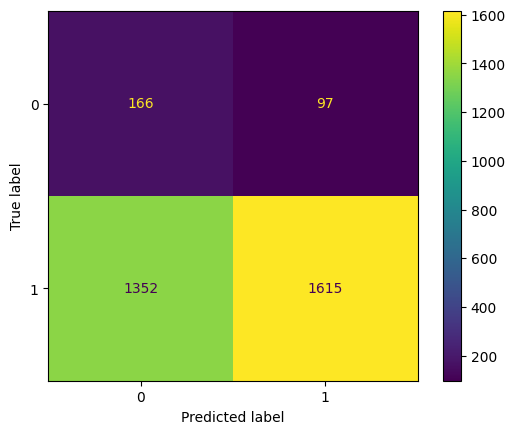

Classification Report: 
               precision    recall  f1-score   support

           0      0.109     0.631     0.186       263
           1      0.943     0.544     0.690      2967

    accuracy                          0.551      3230
   macro avg      0.526     0.588     0.438      3230
weighted avg      0.875     0.551     0.649      3230



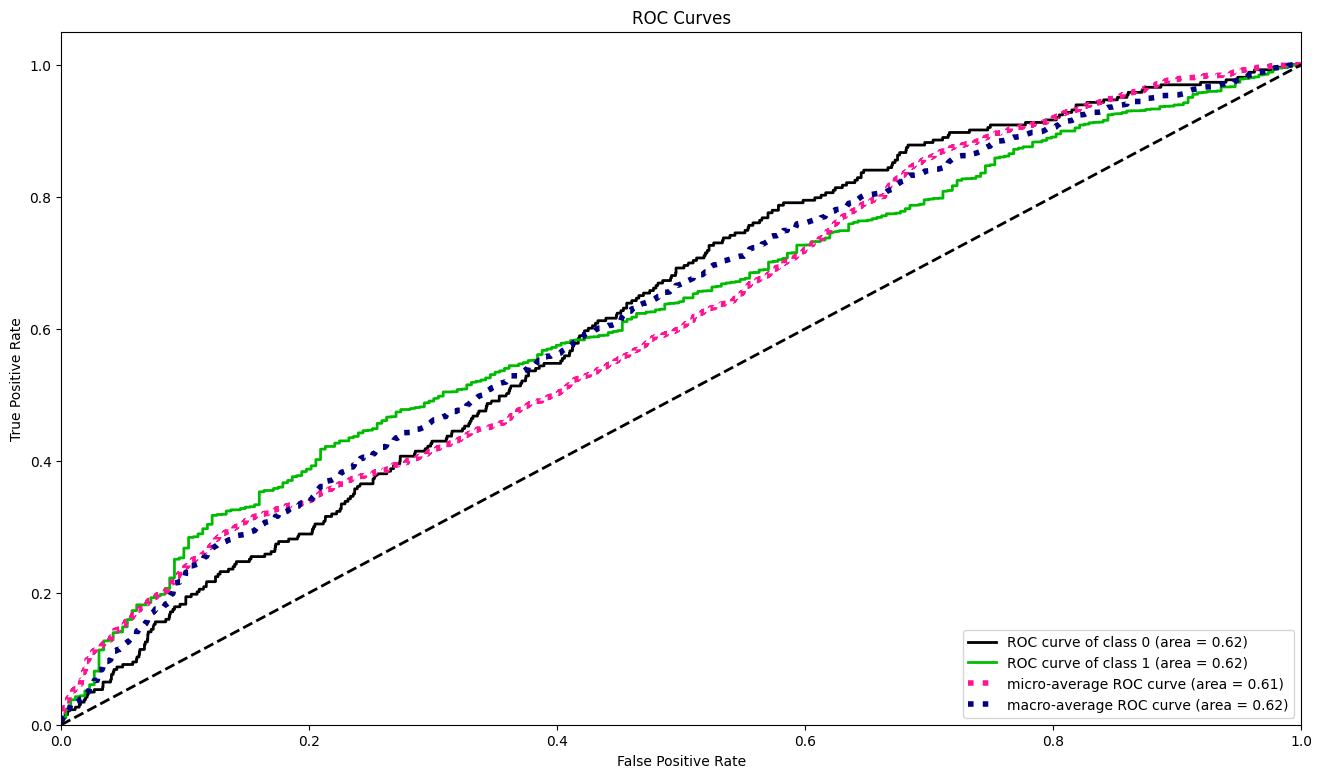

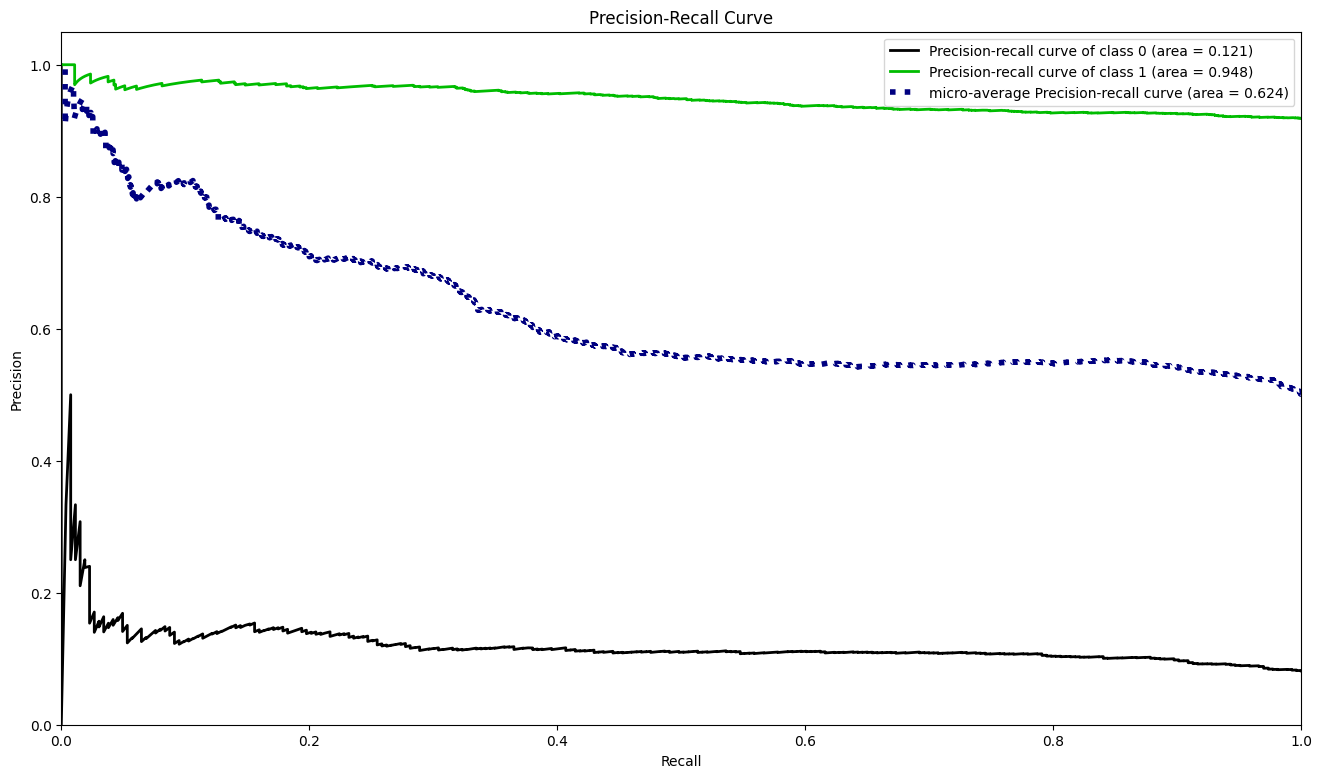

In [379]:
#Using Logistic Regression
lr = LogisticRegression()
model_eval(lr,X_train,y_train,X_test,y_test)

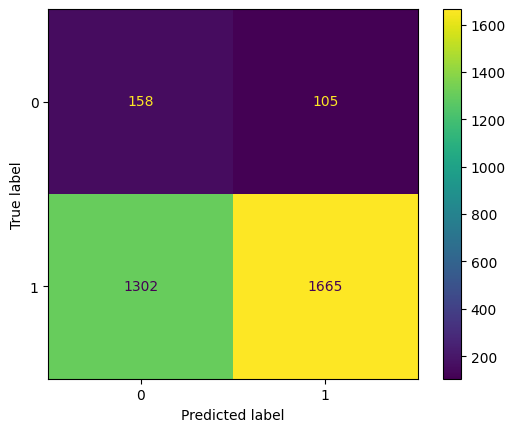

Classification Report: 
               precision    recall  f1-score   support

           0      0.108     0.601     0.183       263
           1      0.941     0.561     0.703      2967

    accuracy                          0.564      3230
   macro avg      0.524     0.581     0.443      3230
weighted avg      0.873     0.564     0.661      3230



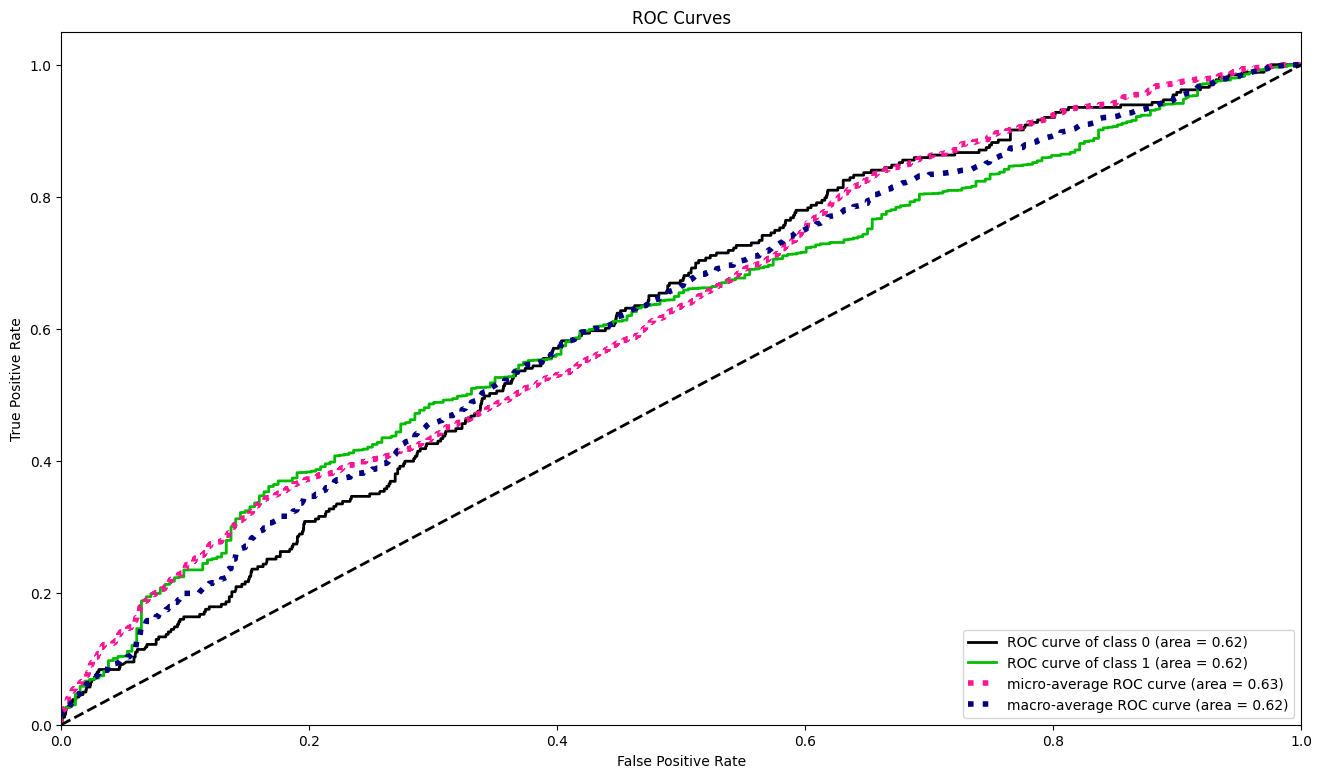

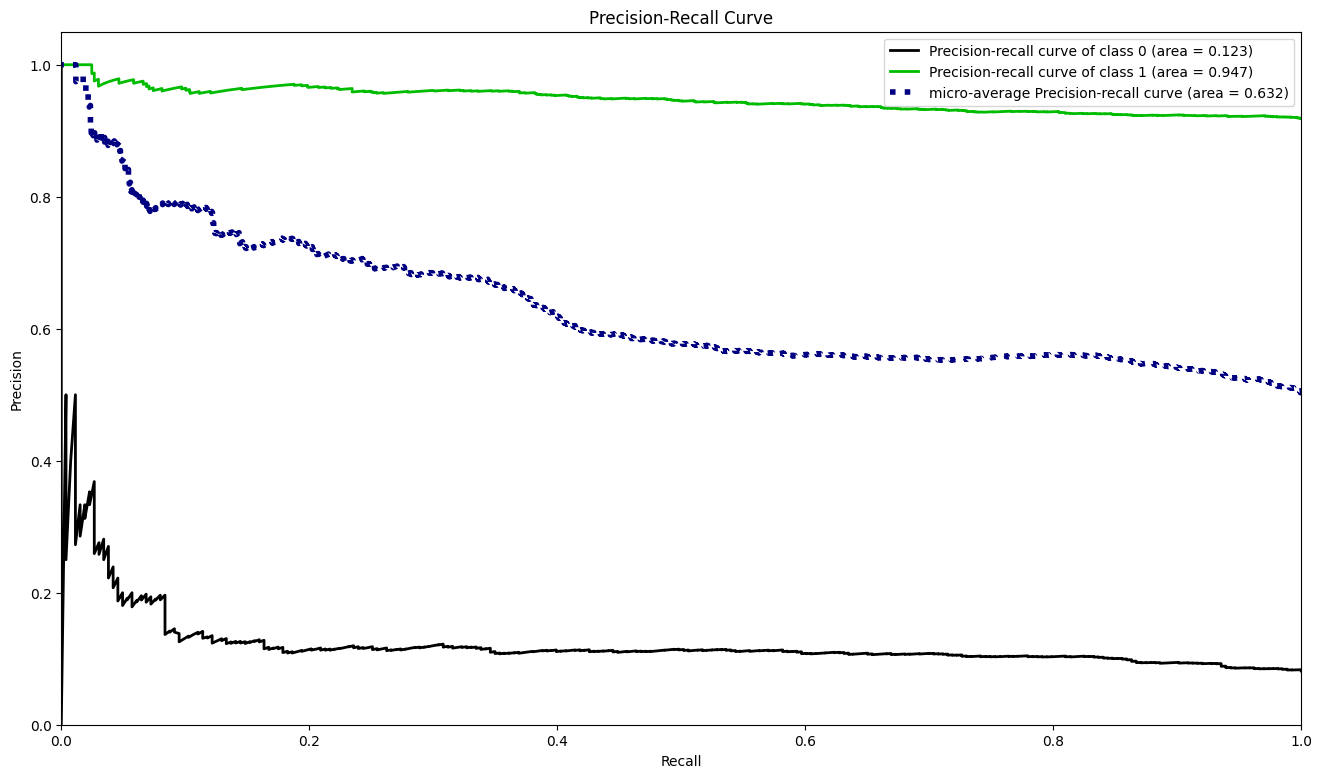

In [380]:
#sekarang kita coba menggunakan Naive Bayes
nb = GaussianNB()
model_eval(nb,X_train,y_train,X_test,y_test)

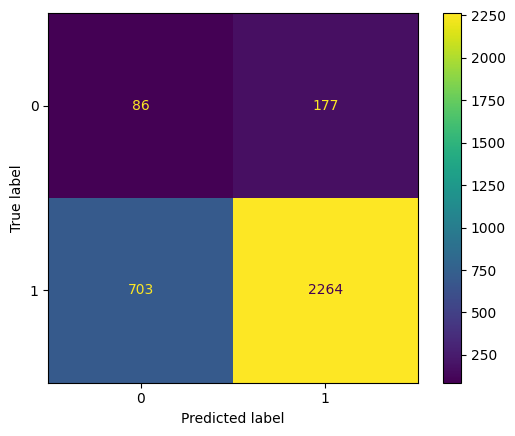

Classification Report: 
               precision    recall  f1-score   support

           0      0.109     0.327     0.163       263
           1      0.927     0.763     0.837      2967

    accuracy                          0.728      3230
   macro avg      0.518     0.545     0.500      3230
weighted avg      0.861     0.728     0.782      3230



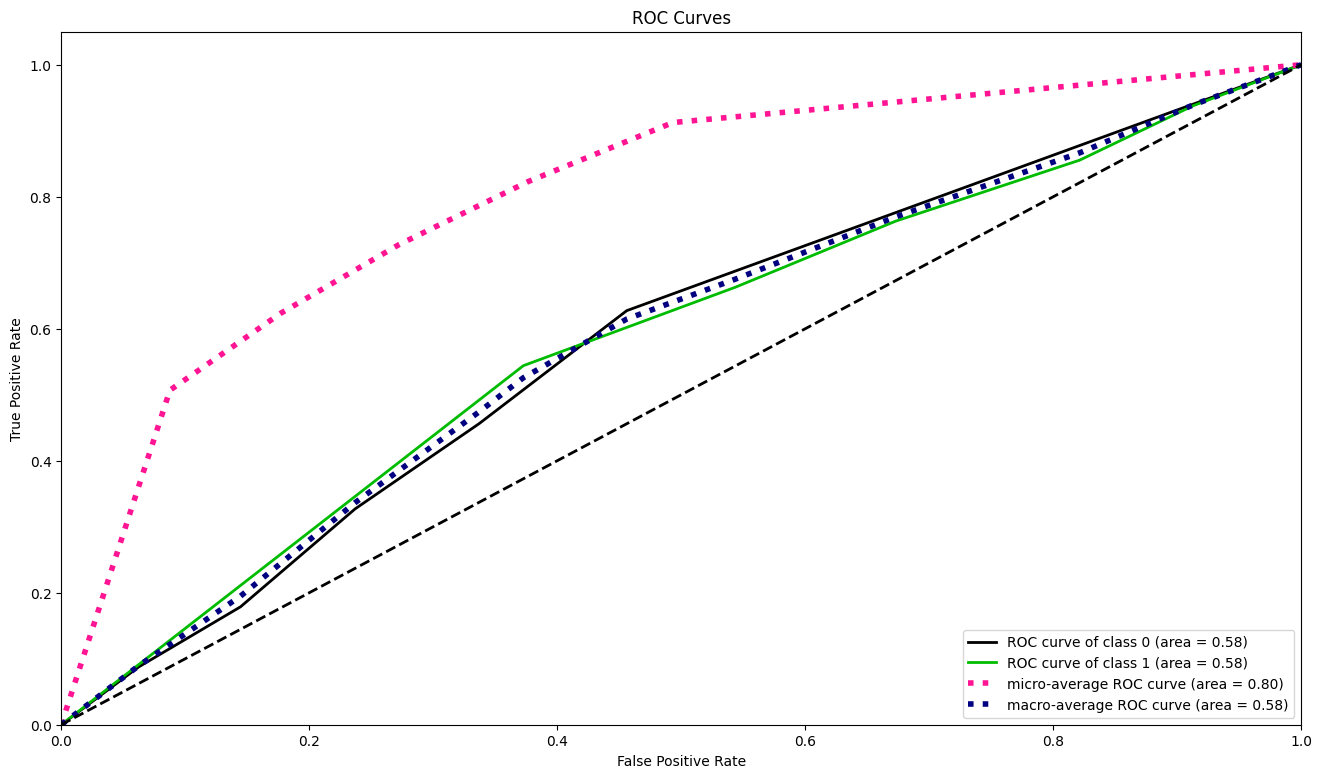

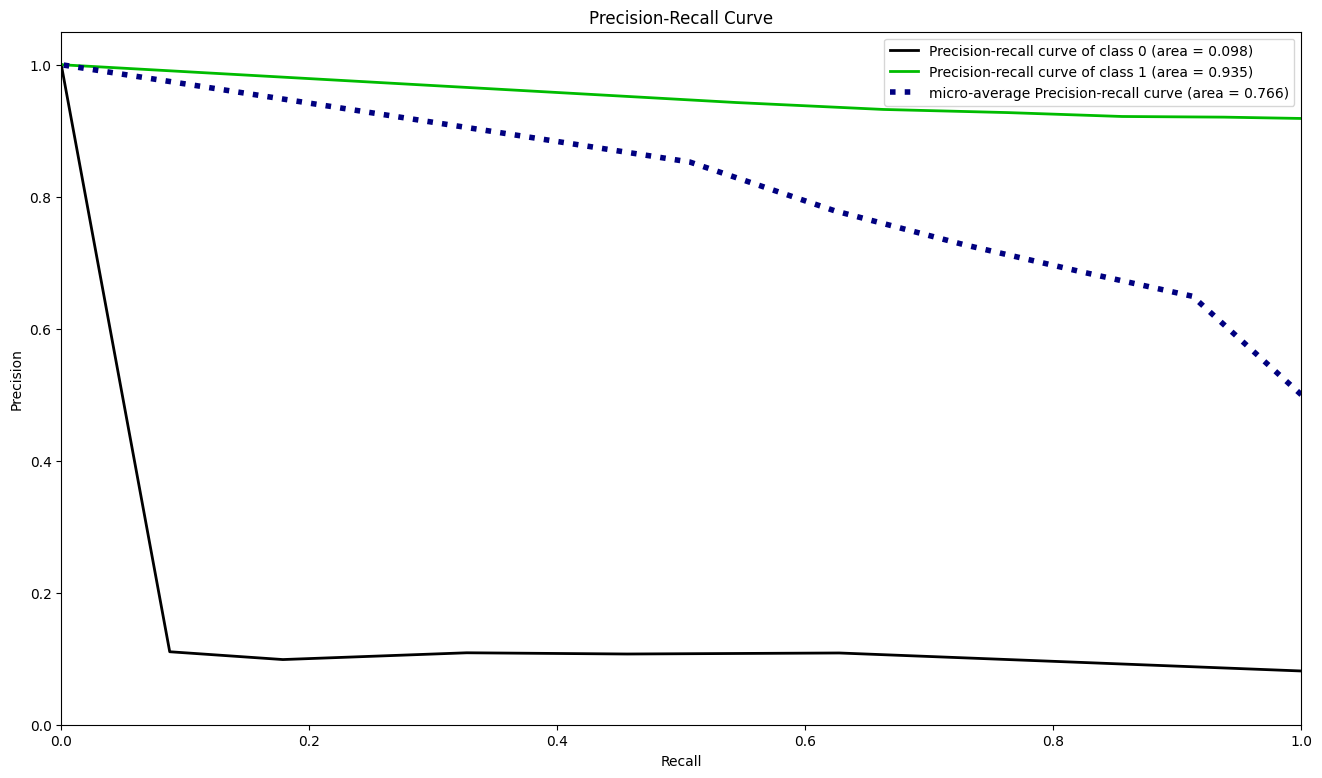

In [381]:
#Sekarang kita coba menggunakan KNN
knn = KNeighborsClassifier()
model_eval(knn,X_train,y_train,X_test,y_test)

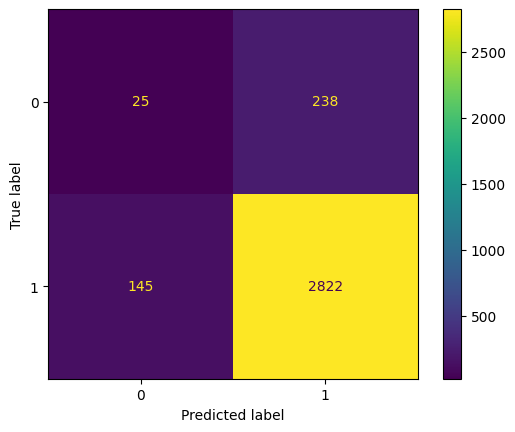

Classification Report: 
               precision    recall  f1-score   support

           0      0.147     0.095     0.115       263
           1      0.922     0.951     0.936      2967

    accuracy                          0.881      3230
   macro avg      0.535     0.523     0.526      3230
weighted avg      0.859     0.881     0.870      3230



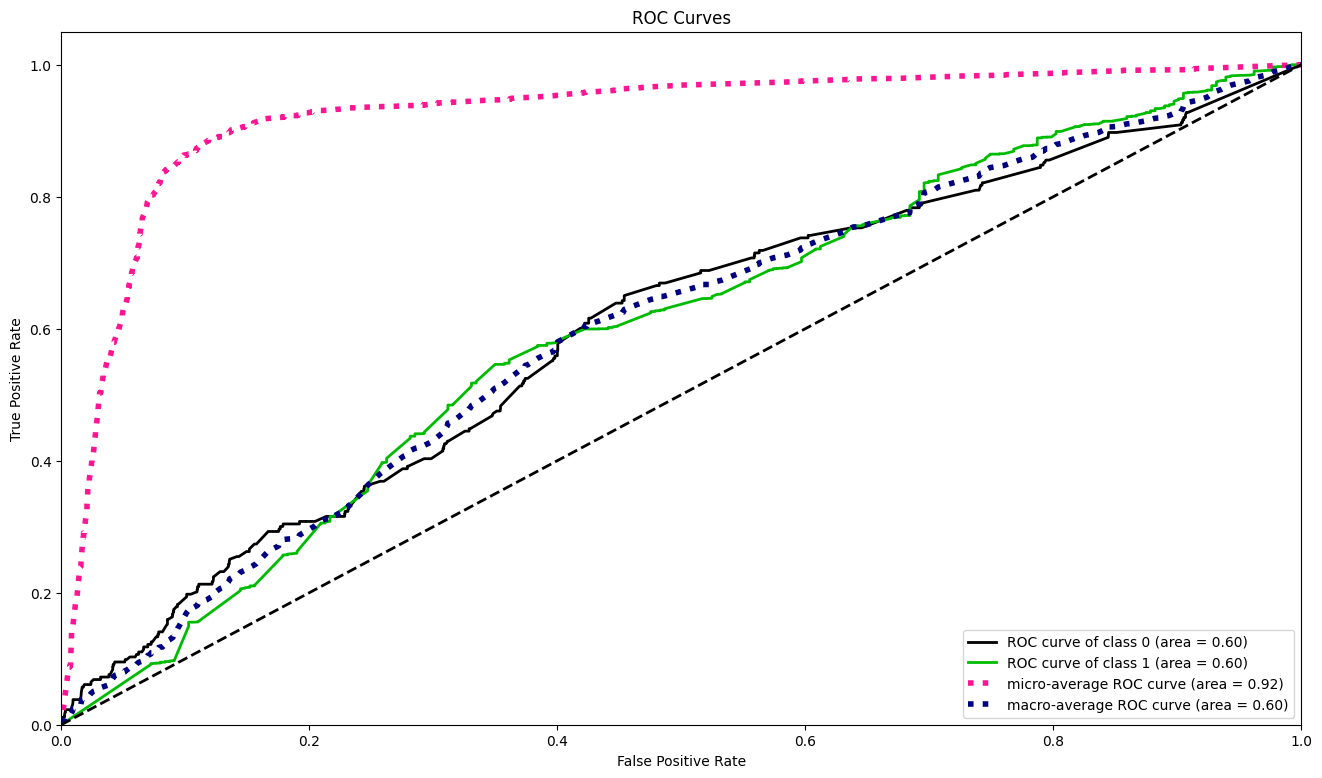

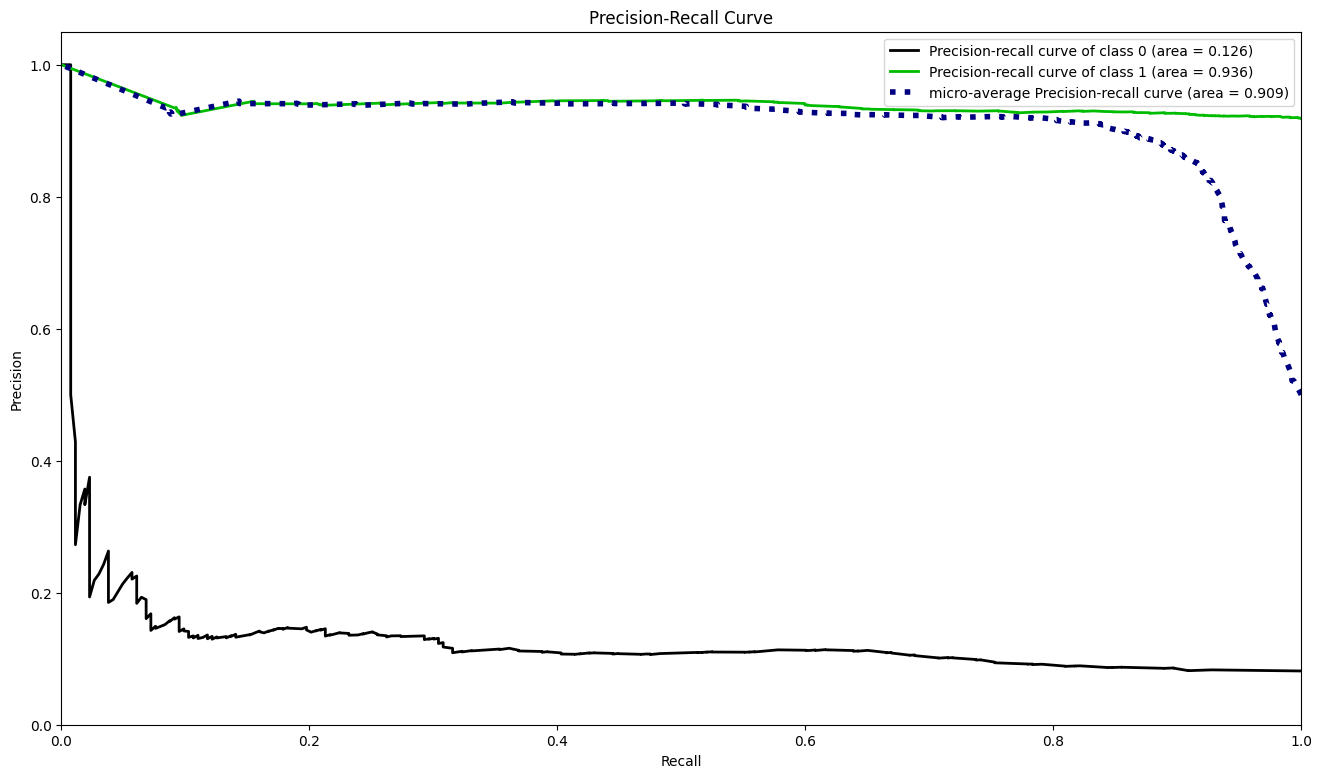

In [382]:
#Sekarang kita coba Random Forest
rf = RandomForestClassifier()
model_eval(rf,X_train,y_train,X_test,y_test)

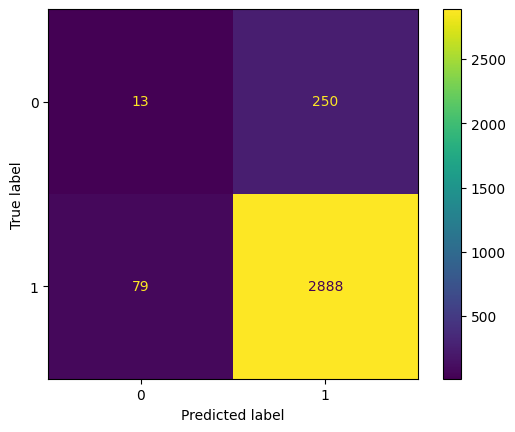

Classification Report: 
               precision    recall  f1-score   support

           0      0.141     0.049     0.073       263
           1      0.920     0.973     0.946      2967

    accuracy                          0.898      3230
   macro avg      0.531     0.511     0.510      3230
weighted avg      0.857     0.898     0.875      3230



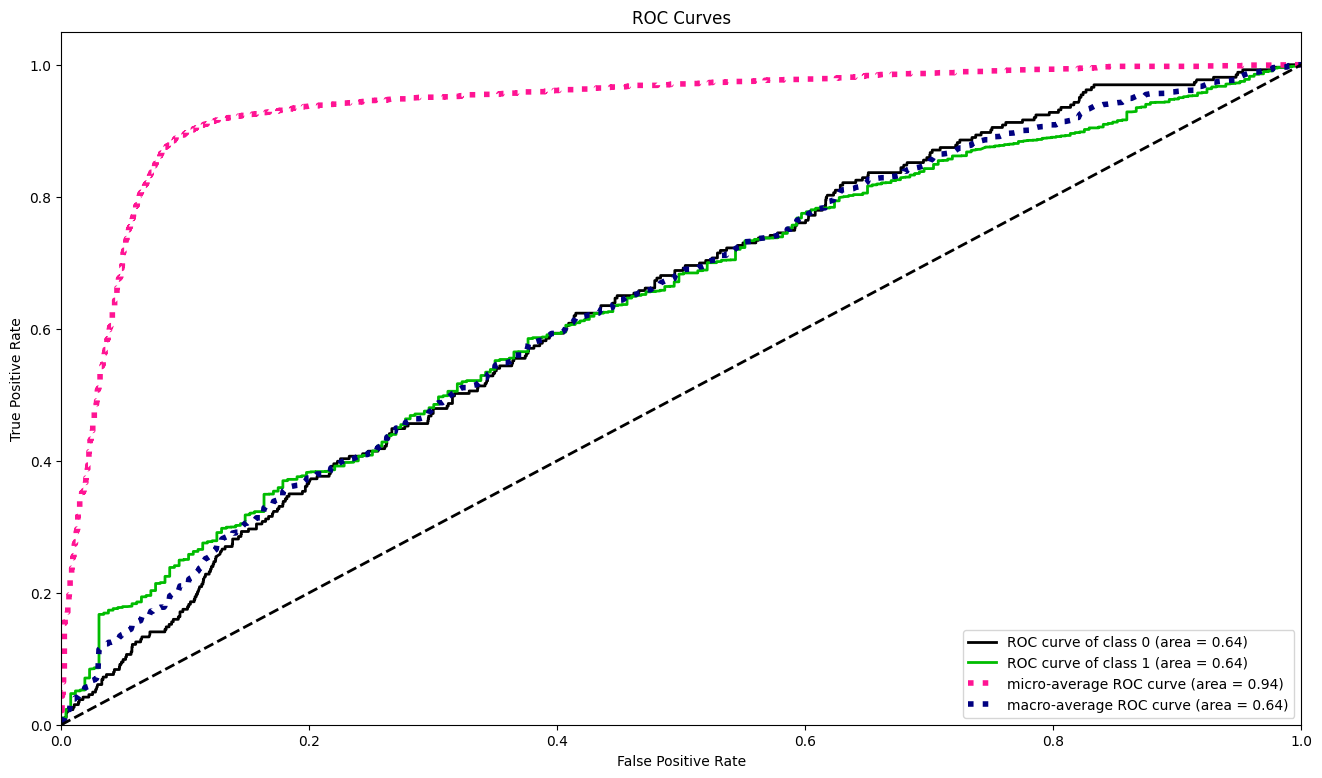

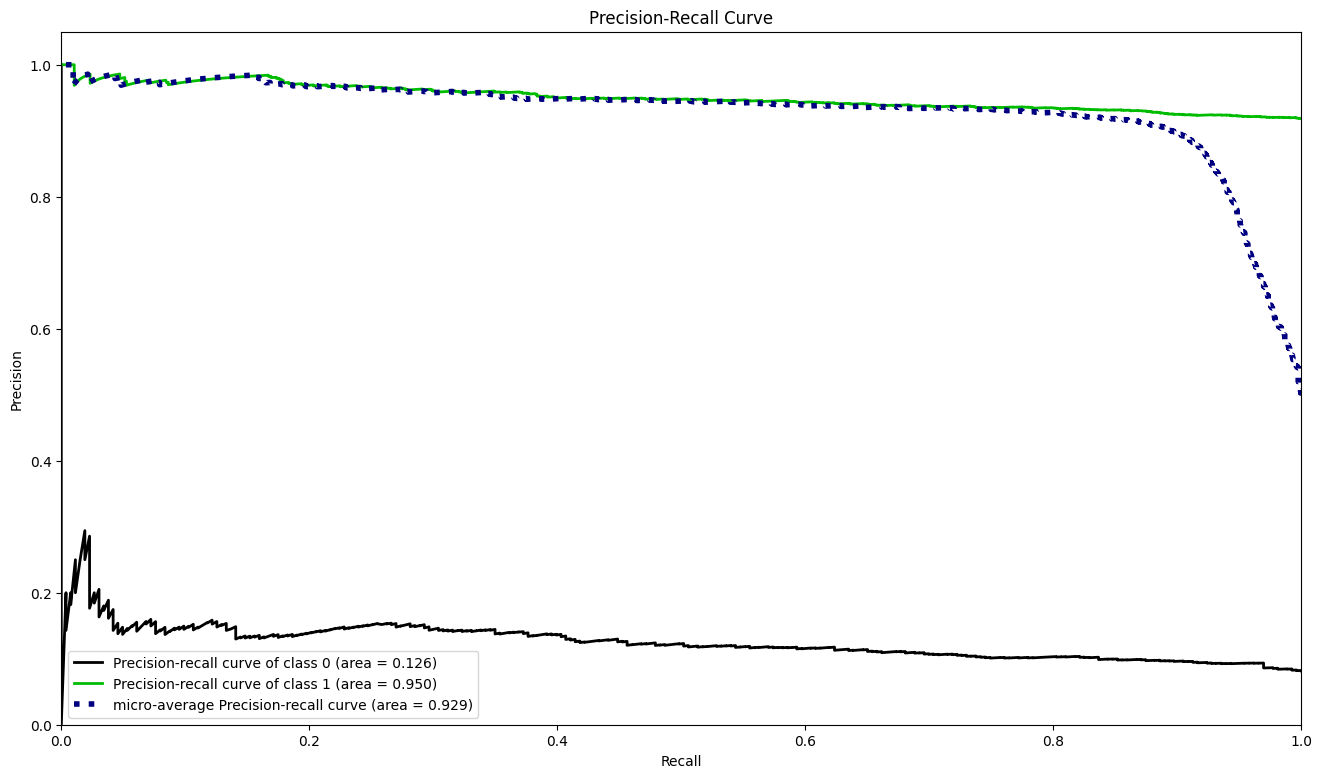

In [383]:
#Sekarang kita coba menggunakan XGBoost
xgb = XGBClassifier()
model_eval(xgb,X_train,y_train,X_test,y_test)

# **4. MODEL TUNNING**

Karena dari model yang di atas bisa kita simpulkan bahwa XGBoost adala yang terbaik namun bisa kita lihat performa Precission dan Recallnya sangat jauh sekali, maka saya meggunakan scoringnya F-1 Score agar keduanya cukup optimal

In [385]:
#kita membuat function opmitasi, disinia saya menggunakan GridSearchCV
def model_opt(clf, params,X_train,y_train,X_test,y_test ):
    # Load GridSearchCV
    search = GridSearchCV(estimator=clf,
                          param_grid=params,
                          scoring = 'f1',
                          n_jobs = -1,
                          cv = 3,
                          verbose=True)

    # Train search object
    search.fit(X_train, y_train)
    
    best = search.best_estimator_
    best_model = best.fit(X_train, y_train)
    
    #### TEST

    y_test_ypred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:,-1]
    y_probas = best_model.predict_proba(X_test)
    
    print('Best parameters: \n',search.best_params_)
    print('='*70)
    #Confussion Matrix
    ConfusionMatrixDisplay.from_estimator(algo, X_test, y_test)
    plt.show() 
    print('='*100)
    print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
    print('='*100)
    
    #ROC Curve
    #fpr,tpr,thresholds = roc_curve(y_test,y_test_prob)
    skplt.metrics.plot_roc(y_test, y_probas,figsize=(16,9) )
    
    #PR Curve
    skplt.metrics.plot_precision_recall(y_test, y_probas, figsize=(16,9))
    plt.show()

In [407]:
X_train = pd.DataFrame(X_train)



In [408]:
X_test = pd.DataFrame(X_test)

In [409]:
params ={"learning_rate"    : [0.05, 0.10, 0.15] ,
         "max_depth"        : [ 3, 4, 5, 6],
         "min_child_weight" : [ 1, 3, 5, 7 ],
         "gamma"            : [ 0.0, 0.1, 0.2 ],
         "colsample_bytree" : [ 0.3, 0.4, 0.5] }

#Saya sudah mencari dengan GridSearcCV dan menemukan parameterterbaik
{'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 1}

#sekarnag kita coba pada model setelah ditunning
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bynode=1, colsample_bytree=0.5, gamma=0.0,
                    learning_rate=0.15, max_delta_step=0, max_depth=6,
                    min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                    nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=None, subsample=1, verbosity=1)

model_eval(xgb,X_train,y_train,X_test,y_test)

XGBoostError: [14:24:26] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\c_api\c_api_utils.h:167: Invalid missing value: null

Ada sedikit peningkatan pada Recall yang sebelumnya 79.5 % sekarang 85.1 %. Memang anatara Recall dan Precission akan teradi trade-off maka saya menggunakan scoring pada GridScearchCV adala F1-Score karena mencoba mengharmonikan keduanya. Perlu diingat kembali bahwa dataset ini imbalance atau tidak seimbang pada target variabelnya.

# **5. DEPLOYMENT**

Setelah semua dirasa cukup dan optimal, sekarang waktunya untuk deployment dengan menggunakan Streamlit dan Heroku. Disini saya anya membuat aplikasi sederhana saja. Untuk melihat lebi detail terkait deployment, sila cek di file yang ada di repository atau untuk melihat hasilnya cek di link berikutt:


https://sba-farras-app.herokuapp.com/

# **6. KESIMPULAN**

Dari semua tahapan yang telah kita lewati, ada beberapa kesimpulan yang bisa daimbil dari project kali ini:

1. Model terbaik adalah XGBoost dengan Micro Average PR AUC 98.9%, Recall 85.1%, Precission 51% hasil paramter tunning sebagai berikut:
  * colsample_bytree: 0.5, 
  * gamma: 0.0, 
  * learning_rate: 0.15, 
  * max_depth: 6, 
  * min_child_weight: 1
  

2. Variabel yang relefan atau berpengaruh terhadap target adalah: 
  * Term 
  * RevLineCr 
  * Portion_SBA_Bank 
  * Is_RetainedJob 
  * DisbursementGross 
  * State_rate 
  * GrAppv 
  * Recssion 
  * Sector_rate 
  

3. Perlu adanya seoarang yang memeiliki backgroung ataupun domain expertise bidang keuangan atau banking karena penentuan treshold pada model tunning sangat mempengaruhi prediksi


4. Dicoba tunning kembali dengan berbagai hyperparamter yang lain, karena kemampuan komputer saya terbatas :)